## Hyperparameter Tuning
A model has few parameters that define its structure. These parameters are not trainable by any sort of optimizing algorithms. These parameters are called Hyperparameters.

Different values of these parameters can have different results. And therefore, we would want to achieve a set of hyperparameters for a given model that give the most favourable results(optimized).

To achieve this, we perform Hyperparameter tuning. In simple terms:-
 - We take a set of parameters to be optimized.
 - Train the model for each set of parameters.
 - Return those parameters that give the best result.

This is a computationally expensive task and there are few commonly used techniques used here like Grid Search and Random Search that can be used to achieve this.

### Grid Search

This technique is a straightforward hyperparameter tuning method. Here, a model is built with every possible combination of all the values provided in the set of hyperparameters, then we evaluate these models, and then choose the architecture that outputs the best results.

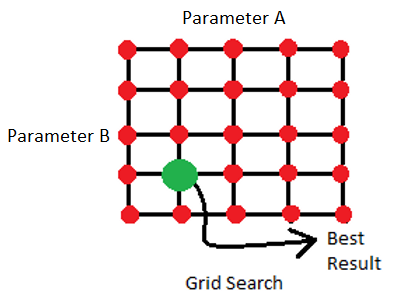

### Random Search
In this technique, for each value of hyperparameters, we give a distribution from which a set of values can be chosen randomly. Hence, the name. The hyperparameter search space is random here and this technique can be useful when we have little knowledge of what specific hyperparameters values to provide.

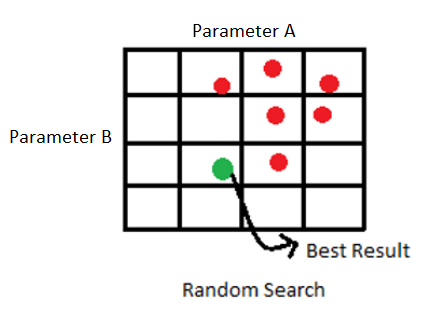

## Scikit-Learn


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, neighbors, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

In [ ]:
X_digits, y_digits = datasets.load_digits(return_X_y=True)
X_digits = X_digits / X_digits.max()

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.2, random_state=42)

In [ ]:
knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [3, 5, 7, 9],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [15, 20]}]
gs_knn = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(X_train, y_train)


print(gs_knn.best_params_)

{'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [ ]:
# find best model score
gs_knn.score(X_test, y_test)

0.9833333333333333

In [ ]:
lr_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('logistic', LogisticRegression(solver='saga', max_iter=2000))])
params = [{'logistic__C': uniform(loc=0, scale=4),
         'logistic__penalty': ['l1', 'l2']}]
rs_lr = RandomizedSearchCV(lr_pipe,
                      param_distributions=params,
                      scoring='accuracy',
                      n_iter=10,
                      cv=5)
rs_lr.fit(X_train, y_train)
print(rs_lr.best_params_)



{'logistic__C': 1.8948824877243067, 'logistic__penalty': 'l2'}


In [ ]:
# find best model score
print(rs_lr.score(X_test, y_test))

0.9694444444444444


### Exercise

You will make predictions on the iris dataset, and tune an MLPClassifier to get a good model.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from scipy.stats import loguniform

In [ ]:
iris= load_iris()

# Store features matrix in X
X= iris.data
#Store target vector in
y= iris.target

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize your MLPClassifier estimator, you can use scaling if you want as shown in the above cells
# Your MLP can have two layers with 3 neurons each, since this is a very small dataset
# http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
mlp_estimator = MLPClassifier(max_iter=2000, hidden_layer_sizes=(3,3))

# Define the hyperparameters to search over (activation, alpha, learning_rate)
params = [{'activation': ['tanh', 'logistic', 'relu'],
         'alpha': loguniform.stats(0.0001, 0.001),
         'learning_rate': ['constant', 'invscaling', 'adaptive']}]

# Create an instance of RandomSearchCV
rs_mlp = RandomizedSearchCV(mlp_estimator,
                      param_distributions=params,
                      scoring='accuracy',
                      n_iter=10,
                      cv=5)

# Fit your instance on the iris dataset
rs_mlp.fit(X_train, y_train)

# Print out the parameters found by RandomSearch
print(rs_mlp.best_params_)

# Print out the score of the best model on the test set
print(rs_mlp.score(X_test, y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron

{'learning_rate': 'constant', 'alpha': 0.00039086503371292655, 'activation': 'tanh'}
0.9333333333333333


# Ray Tune

In [ ]:
!pip install -U "ray[tune]"

## Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback

In [ ]:
def train_mnist(config):
    batch_size = 128
    num_classes = 10
    epochs = 12

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=config["conv_filters"], kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(config["hidden"], activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(
            lr=config["lr"]),
        metrics=["accuracy"])

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])

In [ ]:
analysis = tune.run(
        train_mnist,
        name="exp",
        metric="mean_accuracy",
        mode="max",
        stop={
            "mean_accuracy": 0.99,
        },
        resources_per_trial={
            "gpu": 1
        },
        config={
            "hidden": tune.grid_search([128, 256, 512]),
            "conv_filters": tune.grid_search([16,32,64]),
            "lr": tune.uniform(0.001, 0.1)
        })

2023-03-24 03:59:51,915	INFO worker.py:1553 -- Started a local Ray instance.


(pid=2605) 2023-03-24 03:59:58.246774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=2605) 2023-03-24 03:59:58.246867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=2605) 2023-03-24 03:59:58.246879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(train_mnist pid=2605) Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
11490434/11490434 [==============================] - 0s 0us/step


(train_mnist pid=2605) 2023-03-24 04:00:02.787116: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=2605) WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_54f97_00000,2023-03-24_04-00-26,True,,b497a0b6ae124e38bc70e4422881d4d8,bd9b6d721d1d,7,0.9912,172.28.0.12,2605,26.763,1.68184,26.763,1679630426,0,,7,54f97_00000,0.0055716
train_mnist_54f97_00001,2023-03-24_04-00-48,True,,3790903b6fbe4e56969cfeb4b5c409ff,bd9b6d721d1d,6,0.991717,172.28.0.12,2868,18.1946,2.47468,18.1946,1679630448,0,,6,54f97_00001,0.00498104
train_mnist_54f97_00002,2023-03-24_04-01-10,True,,11909945119342b18db7410581a10780,bd9b6d721d1d,5,0.991183,172.28.0.12,3089,16.7886,2.07274,16.7886,1679630470,0,,5,54f97_00002,0.00363684
train_mnist_54f97_00003,2023-03-24_04-01-30,True,,00f66faa941c4f08b0787270202b2b68,bd9b6d721d1d,5,0.990983,172.28.0.12,3294,15.6175,2.09543,15.6175,1679630490,0,,5,54f97_00003,0.00541139
train_mnist_54f97_00004,2023-03-24_04-01-49,True,,19c742659f8a48f69c413ebc38985401,bd9b6d721d1d,4,0.990517,172.28.0.12,3488,14.1062,2.14944,14.1062,1679630509,0,,4,54f97_00004,0.00360918
train_mnist_54f97_00005,2023-03-24_04-02-08,True,,781469e79c48474595b11320165f0517,bd9b6d721d1d,4,0.990867,172.28.0.12,3679,15.3108,2.2851,15.3108,1679630528,0,,4,54f97_00005,0.00381899
train_mnist_54f97_00006,2023-03-24_04-02-27,True,,c12949015257416cae8e2969ab79bab1,bd9b6d721d1d,5,0.992517,172.28.0.12,3866,15.1894,1.73748,15.1894,1679630547,0,,5,54f97_00006,0.00361705
train_mnist_54f97_00007,2023-03-24_04-02-46,True,,8d671891eee94d5caebc7287519a0efe,bd9b6d721d1d,4,0.9925,172.28.0.12,4061,13.9217,2.45928,13.9217,1679630566,0,,4,54f97_00007,0.00347614
train_mnist_54f97_00008,2023-03-24_04-03-07,True,,f0519835062e484da7ca26431c626606,bd9b6d721d1d,4,0.992883,172.28.0.12,4253,16.4504,2.56493,16.4504,1679630587,0,,4,54f97_00008,0.00364017


(pid=2868) 2023-03-24 04:00:29.081021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=2868) 2023-03-24 04:00:29.081106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=2868) 2023-03-24 04:00:29.081118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
(train_mnist pid=2868) 2023-03-24 04:00:32.524799: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value

In [ ]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'hidden': 512, 'conv_filters': 64, 'lr': 0.01827486172641303}


### Exercise

Copy the above code cells, and tune the dropout probability, kernel size [(1,1), (3,3), (5,5)], and activation function for the hidden layers (sigmoid, tanh, relu).

Perform a grid search over the kernel size and activation functions, since they are discrete valued, and sample the dropout probability from (0,1).

In [ ]:
# Code here
def train_mnist(config):
    batch_size = 128
    num_classes = 10
    epochs = 12

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=16, kernel_size=config["kernel_size"], activation=config["activation"], input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=config["activation"]),
        tf.keras.layers.Dropout(config["dropout_prob"]),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(
            lr=0.005),
        metrics=["accuracy"])

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])

In [ ]:
analysis = tune.run(
        train_mnist,
        name="exp",
        metric="mean_accuracy",
        mode="max",
        stop={
            "mean_accuracy": 0.99,
        },
        resources_per_trial={
            "gpu": 1
        },
        config={
            "kernel_size": tune.grid_search([(1,1), (3,3), (5,5)]),
            "activation": tune.grid_search(['sigmoid','tanh','relu']),
            "dropout_prob": tune.uniform(0, 1)
        })

(pid=4445) 2023-03-24 04:03:10.775323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=4445) 2023-03-24 04:03:10.775407: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=4445) 2023-03-24 04:03:10.775420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
(train_mnist pid=4445) 2023-03-24 04:03:13.819895: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_c8f94_00000,2023-03-24_04-03-40,True,,2394eb6a02a54ed6864ce36dab5b9bb2,"0_activation=sigmoid,dropout_prob=0.8673,kernel_size=1_1",bd9b6d721d1d,12,0.11235,172.28.0.12,4445,28.989,1.7373,28.989,1679630620,0,,12,c8f94_00000,0.00336766
train_mnist_c8f94_00001,2023-03-24_04-04-15,True,,a0fd0cd7f3844c8f99e09b54320fc1a2,"1_activation=tanh,dropout_prob=0.5351,kernel_size=1_1",bd9b6d721d1d,12,0.950017,172.28.0.12,4770,28.7073,2.4851,28.7073,1679630655,0,,12,c8f94_00001,0.00559139
train_mnist_c8f94_00002,2023-03-24_04-04-49,True,,815439c9ce9f45d2b5f74c720fdc8b78,"2_activation=relu,dropout_prob=0.4158,kernel_size=1_1",bd9b6d721d1d,12,0.959967,172.28.0.12,5069,28.9803,1.75191,28.9803,1679630689,0,,12,c8f94_00002,0.00379372
train_mnist_c8f94_00003,2023-03-24_04-05-22,True,,6852fdcfaafa4112839fad7339018aaf,"3_activation=sigmoid,dropout_prob=0.9381,kernel_size=3_3",bd9b6d721d1d,12,0.1117,172.28.0.12,5356,28.9126,1.70287,28.9126,1679630722,0,,12,c8f94_00003,0.00385427
train_mnist_c8f94_00004,2023-03-24_04-05-48,True,,e4f4855e124c443abc9b57bb7d501704,,bd9b6d721d1d,8,0.990117,172.28.0.12,5641,21.3202,1.73584,21.3202,1679630748,0,,8,c8f94_00004,0.0103621
train_mnist_c8f94_00005,2023-03-24_04-06-07,True,,3b5800e513d249f18772eb0c06d7b5a2,,bd9b6d721d1d,5,0.990017,172.28.0.12,5880,15.3034,1.73288,15.3034,1679630767,0,,5,c8f94_00005,0.00370336
train_mnist_c8f94_00006,2023-03-24_04-06-40,True,,f20f42f5699b43b698e4e3589f2b10fa,"6_activation=sigmoid,dropout_prob=0.8206,kernel_size=5_5",bd9b6d721d1d,12,0.852217,172.28.0.12,6072,28.2822,1.97957,28.2822,1679630800,0,,12,c8f94_00006,0.00512838
train_mnist_c8f94_00007,2023-03-24_04-07-01,True,,be161d77874046b083dd65c76709fb49,,bd9b6d721d1d,5,0.990983,172.28.0.12,6362,16.0801,1.72316,16.0801,1679630821,0,,5,c8f94_00007,0.00363326
train_mnist_c8f94_00008,2023-03-24_04-07-34,True,,7c27c358ce48491496f88269f8c53eda,"8_activation=relu,dropout_prob=0.8711,kernel_size=5_5",bd9b6d721d1d,12,0.887417,172.28.0.12,6569,29.0072,1.70497,29.0072,1679630854,0,,12,c8f94_00008,0.00365019


2023-03-24 04:03:40,975	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}
(pid=4770) 2023-03-24 04:03:45.568649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=4770) 2023-03-24 04:03:45.568785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=4770) 2023-03-24 04:03:45.568807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are insta

In [ ]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'kernel_size': (5, 5), 'activation': 'tanh', 'dropout_prob': 0.0806650809513938}


## PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import ray
from ray import tune

In [ ]:
EPOCH_SIZE = 512
TEST_SIZE = 256

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, config):
        super(ConvNet, self).__init__()
        self.config = config
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc1 = nn.Linear(192, config['hidden'])
        self.fc2 = nn.Linear(config['hidden'], 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def train(model, optimizer, train_loader, device=None):
    device = device or torch.device("cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, data_loader, device=None):
    device = device or torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [ ]:
def get_data_loaders():
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "~/data",
            train=True,
            download=True,
            transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "~/data",
            train=False,
            download=True,
            transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    return train_loader, test_loader

In [ ]:
def train_mnist(config):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, test_loader = get_data_loaders()
    model = ConvNet(config).to(device)

    optimizer = optim.Adam(
        model.parameters(), lr=config["lr"])

    while True:
        train(model, optimizer, train_loader, device)
        acc = test(model, test_loader, device)
        # Set this to run Tune.
        tune.report(mean_accuracy=acc)

In [ ]:
analysis = tune.run(
    train_mnist,
    metric="mean_accuracy",
    mode="max",
    name="exp",
    stop={
        "mean_accuracy": 0.98,
        "training_iteration": 10
    },
    resources_per_trial={
        "gpu": 1
    },
    config={
      "hidden": tune.grid_search([16, 32, 64, 128, 256, 512]),
      "lr": tune.uniform(0.001, 0.1)
    })

(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /root/data/MNIST/raw/train-images-idx3-ubyte.gz


100%|██████████| 9912422/9912422 [00:00<00:00, 93121160.13it/s]


(train_mnist pid=6864) Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw
(train_mnist pid=6864) 
(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw/train-labels-idx1-ubyte.gz
(train_mnist pid=6864) Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw
(train_mnist pid=6864) 
(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz


100%|██████████| 1648877/1648877 [00:00<00:00, 26306667.67it/s]


(train_mnist pid=6864) Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw
(train_mnist pid=6864) 
(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(train_mnist pid=6864) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(train_mnist pid=6864) Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw
(train_mnist pid=6864) 


100%|██████████| 4542/4542 [00:00<00:00, 33717750.03it/s]


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_68212_00000,2023-03-24_04-07-52,True,,314183a87a8b404987a18e7ba810634f,bd9b6d721d1d,10,0.809375,172.28.0.12,6864,14.5031,0.248343,14.5031,1679630872,0,,10,68212_00000,0.00359988
train_mnist_68212_00001,2023-03-24_04-08-06,True,,1cf914b5741c48c9b9e6eac1db6bec37,bd9b6d721d1d,10,0.934375,172.28.0.12,7003,10.4763,0.267635,10.4763,1679630886,0,,10,68212_00001,0.00454926
train_mnist_68212_00002,2023-03-24_04-08-18,True,,83be16d34e2d414fb544968a64a31cfb,bd9b6d721d1d,10,0.078125,172.28.0.12,7112,7.6628,0.32556,7.6628,1679630898,0,,10,68212_00002,0.00495911
train_mnist_68212_00003,2023-03-24_04-08-31,True,,59684ecd4d834a91a8a01c7c7b2cc797,bd9b6d721d1d,10,0.8625,172.28.0.12,7210,7.47908,0.259526,7.47908,1679630911,0,,10,68212_00003,0.00407934
train_mnist_68212_00004,2023-03-24_04-08-41,True,,abe14f2c01574d53a78ecd892b50e4ec,bd9b6d721d1d,10,0.15,172.28.0.12,7304,6.61276,0.416155,6.61276,1679630921,0,,10,68212_00004,0.00373387
train_mnist_68212_00005,2023-03-24_04-08-51,True,,b72ff7fb93e14a52a366a6db07a53051,bd9b6d721d1d,10,0.9375,172.28.0.12,7389,5.98274,0.267971,5.98274,1679630931,0,,10,68212_00005,0.00388718


2023-03-24 04:08:51,209	INFO tune.py:798 -- Total run time: 76.29 seconds (76.25 seconds for the tuning loop).


In [ ]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'hidden': 512, 'lr': 0.009760333623601642}


# Hyperband

- Some hyperparameter optimization algorithms are written as "scheduling algorithms"
- These schedulers can early terminate bad trials, pause trials, clone trials, and alter hyperparameters of a running trial.
-  HyperBand is an early stopping scheduling algorithm. It divides trials into brackets of varying sizes, and periodically early stops low-performing trials within each bracket.

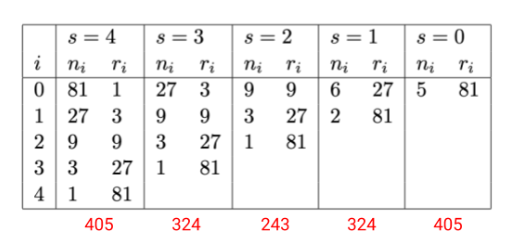

HyperBand algorithm details
 - There's a fixed budget $B$ of a resource, total resources in a bracket will not exceed the budget
 - Within each bracket, initially the resource is divided equally among all the models.
 - Once a run is completed, lowest $n$ models are discarded.
 - Once each bracket is completed, we just select the best model of all the brackets.

### Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback
from ray.tune.schedulers import HyperBandScheduler

In [ ]:
def train_mnist(config):
    batch_size = 128
    num_classes = 10
    epochs = 12

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=config["conv_filters"], kernel_size=config["kernel_size"], activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(config["hidden"], activation="relu"),
        tf.keras.layers.Dropout(config["dropout"]),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(
            lr=config["lr"]),
        metrics=["accuracy"])

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])

In [ ]:
hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration',
    metric='mean_accuracy',
    mode='max',
    max_t=10,
    reduction_factor=3)

In [ ]:
analysis = tune.run(
        train_mnist,
        name="exp",
        resources_per_trial={
            "gpu": 1,
            "cpu": 4
        },
        config={
            "hidden": tune.grid_search([128, 256, 512]),
            "conv_filters": tune.grid_search([16,32,64]),
            "kernel_size": tune.grid_search([(1,1), (3,3), (5,5)]),
            "dropout": tune.uniform(0, 1),
            "lr": tune.uniform(0.001, 0.1)
        },
        scheduler=hyperband_scheduler)

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr
train_mnist_fed23_00011,RUNNING,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104
train_mnist_fed23_00005,PENDING,,64,0.281076,256,"(1, 1)",0.061059
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499
train_mnist_fed23_00008,PENDING,,64,0.927756,512,"(1, 1)",0.0458031


(train_mnist pid=6322) 2022-04-11 17:08:27.545166: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=6322) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=6322)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr
train_mnist_fed23_00011,RUNNING,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104
train_mnist_fed23_00005,PENDING,,64,0.281076,256,"(1, 1)",0.061059
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499
train_mnist_fed23_00008,PENDING,,64,0.927756,512,"(1, 1)",0.0458031


Result for train_mnist_fed23_00011:
  date: 2022-04-11_17-08-31
  done: false
  experiment_id: 1f2fc09406a447c2808fd0063b74dfd3
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10365000367164612
  node_ip: 172.28.0.2
  pid: 6322
  time_since_restore: 4.846079587936401
  time_this_iter_s: 4.846079587936401
  time_total_s: 4.846079587936401
  timestamp: 1649696911
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00011
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00005,PENDING,,64,0.281076,256,"(1, 1)",0.061059,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499,,,
train_mnist_fed23_00008,PENDING,,64,0.927756,512,"(1, 1)",0.0458031,,,


(train_mnist pid=6486) 2022-04-11 17:08:38.287841: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=6486) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=6486)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00005,RUNNING,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,,,
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499,,,
train_mnist_fed23_00008,PENDING,,64,0.927756,512,"(1, 1)",0.0458031,,,


Result for train_mnist_fed23_00005:
  date: 2022-04-11_17-08-42
  done: false
  experiment_id: fb4b27494b66437dbaf9dd700ee2cec0
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10661666840314865
  node_ip: 172.28.0.2
  pid: 6486
  time_since_restore: 5.1445982456207275
  time_this_iter_s: 5.1445982456207275
  time_total_s: 5.1445982456207275
  timestamp: 1649696922
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00005
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00005,RUNNING,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106617,1,5.1446
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499,,,
train_mnist_fed23_00008,PENDING,,64,0.927756,512,"(1, 1)",0.0458031,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499,,,
train_mnist_fed23_00008,PENDING,,64,0.927756,512,"(1, 1)",0.0458031,,,


(train_mnist pid=6571) 2022-04-11 17:08:53.318342: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=6571) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=6571)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00009,RUNNING,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,,,
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499,,,


Result for train_mnist_fed23_00009:
  date: 2022-04-11_17-08-56
  done: false
  experiment_id: b2bbc82836a34888b704b394b2502fab
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10641666501760483
  node_ip: 172.28.0.2
  pid: 6571
  time_since_restore: 4.425048589706421
  time_this_iter_s: 4.425048589706421
  time_total_s: 4.425048589706421
  timestamp: 1649696936
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00009
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,
train_mnist_fed23_00007,PENDING,,32,0.101061,512,"(1, 1)",0.0113499,,,


(train_mnist pid=6641) 2022-04-11 17:09:03.303901: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=6641) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=6641)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00013,RUNNING,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,,,
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Result for train_mnist_fed23_00013:
  date: 2022-04-11_17-09-07
  done: false
  experiment_id: 8bd9b3866e71486b836a67ca14f140f4
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10586666315793991
  node_ip: 172.28.0.2
  pid: 6641
  time_since_restore: 4.869135856628418
  time_this_iter_s: 4.869135856628418
  time_total_s: 4.869135856628418
  timestamp: 1649696947
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00013
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00000,PENDING,,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


(train_mnist pid=6711) 2022-04-11 17:09:13.663541: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=6711) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=6711)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,RUNNING,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,,,
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Result for train_mnist_fed23_00000:
  date: 2022-04-11_17-09-16
  done: false
  experiment_id: 250ab352b7f7472fb60ad0217d6c5912
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.44620001316070557
  node_ip: 172.28.0.2
  pid: 6711
  time_since_restore: 4.470707654953003
  time_this_iter_s: 4.470707654953003
  time_total_s: 4.470707654953003
  timestamp: 1649696956
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00000
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,RUNNING,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.521383,2,5.83203
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Result for train_mnist_fed23_00000:
  date: 2022-04-11_17-09-22
  done: false
  experiment_id: 250ab352b7f7472fb60ad0217d6c5912
  hostname: d179f880fe88
  iterations_since_restore: 5
  mean_accuracy: 0.5580166578292847
  node_ip: 172.28.0.2
  pid: 6711
  time_since_restore: 9.891154289245605
  time_this_iter_s: 1.3384478092193604
  time_total_s: 9.891154289245605
  timestamp: 1649696962
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: fed23_00000
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,RUNNING,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.569617,7,12.585
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Result for train_mnist_fed23_00000:
  date: 2022-04-11_17-09-27
  done: false
  experiment_id: 250ab352b7f7472fb60ad0217d6c5912
  hostname: d179f880fe88
  iterations_since_restore: 9
  mean_accuracy: 0.5795666575431824
  node_ip: 172.28.0.2
  pid: 6711
  time_since_restore: 15.278056383132935
  time_this_iter_s: 1.3426642417907715
  time_total_s: 15.278056383132935
  timestamp: 1649696967
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: fed23_00000
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00002,PENDING,,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00002,RUNNING,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


(train_mnist pid=6853) 2022-04-11 17:09:36.306804: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=6853) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=6853)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00002:
  date: 2022-04-11_17-09-40
  done: false
  experiment_id: 4d8b5e339ce1472ba3006091d48a1200
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10814999788999557
  node_ip: 172.28.0.2
  pid: 6853
  time_since_restore: 4.913837194442749
  time_this_iter_s: 4.913837194442749
  time_total_s: 4.913837194442749
  timestamp: 1649696980
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00002
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00002,RUNNING,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.10815,1,4.91384
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Result for train_mnist_fed23_00002:
  date: 2022-04-11_17-09-45
  done: false
  experiment_id: 4d8b5e339ce1472ba3006091d48a1200
  hostname: d179f880fe88
  iterations_since_restore: 4
  mean_accuracy: 0.10559999942779541
  node_ip: 172.28.0.2
  pid: 6853
  time_since_restore: 10.391936302185059
  time_this_iter_s: 1.8157637119293213
  time_total_s: 10.391936302185059
  timestamp: 1649696985
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: fed23_00002
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00002,RUNNING,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.1056,4,10.3919
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Result for train_mnist_fed23_00002:
  date: 2022-04-11_17-09-51
  done: false
  experiment_id: 4d8b5e339ce1472ba3006091d48a1200
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.1070166677236557
  node_ip: 172.28.0.2
  pid: 6853
  time_since_restore: 15.866953134536743
  time_this_iter_s: 1.8375418186187744
  time_total_s: 15.866953134536743
  timestamp: 1649696991
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: fed23_00002
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00002,RUNNING,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.107017,7,15.867
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Result for train_mnist_fed23_00002:
  date: 2022-04-11_17-09-56
  done: false
  experiment_id: 4d8b5e339ce1472ba3006091d48a1200
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.10593333095312119
  node_ip: 172.28.0.2
  pid: 6853
  time_since_restore: 21.29803442955017
  time_this_iter_s: 1.8091576099395752
  time_total_s: 21.29803442955017
  timestamp: 1649696996
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: fed23_00002
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00006,PENDING,,16,0.952117,512,"(1, 1)",0.0725301,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00007,RUNNING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,


(train_mnist pid=6991) 2022-04-11 17:10:03.366037: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=6991) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=6991)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00007,RUNNING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,


Result for train_mnist_fed23_00007:
  date: 2022-04-11_17-10-06
  done: false
  experiment_id: 7332931038b0411a9f72cdb66b8e3b48
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.914566695690155
  node_ip: 172.28.0.2
  pid: 6991
  time_since_restore: 4.76303505897522
  time_this_iter_s: 4.76303505897522
  time_total_s: 4.76303505897522
  timestamp: 1649697006
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00007
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00008,RUNNING,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,


(train_mnist pid=7078) 2022-04-11 17:10:17.235494: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7078) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7078)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00008:
  date: 2022-04-11_17-10-21
  done: false
  experiment_id: 8e0b9cce8edf478488546688c72013be
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10646666586399078
  node_ip: 172.28.0.2
  pid: 7078
  time_since_restore: 5.322134256362915
  time_this_iter_s: 5.322134256362915
  time_total_s: 5.322134256362915
  timestamp: 1649697021
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00008
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00003,PENDING,,16,0.165804,256,"(1, 1)",0.0827596,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00003,RUNNING,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,


(train_mnist pid=7150) 2022-04-11 17:10:28.316043: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7150) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7150)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00003:
  date: 2022-04-11_17-10-31
  done: false
  experiment_id: 9d53441aa3c54cdca891058f51f73270
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10606666654348373
  node_ip: 172.28.0.2
  pid: 7150
  time_since_restore: 4.429468154907227
  time_this_iter_s: 4.429468154907227
  time_total_s: 4.429468154907227
  timestamp: 1649697031
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00003
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00003,RUNNING,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.106067,1,4.42947
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00001,PENDING,,32,0.113803,128,"(1, 1)",0.0576492,,,


(train_mnist pid=7236) 2022-04-11 17:10:41.280901: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7236) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7236)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00012,RUNNING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914


Result for train_mnist_fed23_00012:
  date: 2022-04-11_17-10-44
  done: false
  experiment_id: 9e53aa97cb6e4c30a8bf3527ae9cdcac
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.9046666622161865
  node_ip: 172.28.0.2
  pid: 7236
  time_since_restore: 4.424107789993286
  time_this_iter_s: 4.424107789993286
  time_total_s: 4.424107789993286
  timestamp: 1649697044
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00012
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914


(train_mnist pid=7307) 2022-04-11 17:10:51.307696: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7307) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7307)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00014,RUNNING,172.28.0.2:7307,64,0.404234,256,"(3, 3)",0.0709394,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411


Result for train_mnist_fed23_00014:
  date: 2022-04-11_17-10-55
  done: false
  experiment_id: c9349e6cc97d4890ac4a0fc3ec98fd82
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10386666655540466
  node_ip: 172.28.0.2
  pid: 7307
  time_since_restore: 5.038286447525024
  time_this_iter_s: 5.038286447525024
  time_total_s: 5.038286447525024
  timestamp: 1649697055
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00014
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00016,RUNNING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411


(train_mnist pid=7378) 2022-04-11 17:11:02.301572: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7378) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7378)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00016:
  date: 2022-04-11_17-11-05
  done: false
  experiment_id: 7ed2ea9c79ad4f6d82ea2f42278e0ba5
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.9457833170890808
  node_ip: 172.28.0.2
  pid: 7378
  time_since_restore: 4.846174001693726
  time_this_iter_s: 4.846174001693726
  time_total_s: 4.846174001693726
  timestamp: 1649697065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00016
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00001,RUNNING,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,,,
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411


(train_mnist pid=7448) 2022-04-11 17:11:13.328922: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7448) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7448)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00001:
  date: 2022-04-11_17-11-16
  done: false
  experiment_id: 2977e3ffcd864f6293c8ceb99d1c1cfb
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10811666399240494
  node_ip: 172.28.0.2
  pid: 7448
  time_since_restore: 4.524639844894409
  time_this_iter_s: 4.524639844894409
  time_total_s: 4.524639844894409
  timestamp: 1649697076
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00001
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00001,RUNNING,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.10505,2,5.9794
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411


Result for train_mnist_fed23_00001:
  date: 2022-04-11_17-11-22
  done: false
  experiment_id: 2977e3ffcd864f6293c8ceb99d1c1cfb
  hostname: d179f880fe88
  iterations_since_restore: 5
  mean_accuracy: 0.10538333654403687
  node_ip: 172.28.0.2
  pid: 7448
  time_since_restore: 10.309475183486938
  time_this_iter_s: 1.440321683883667
  time_total_s: 10.309475183486938
  timestamp: 1649697082
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: fed23_00001
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00001,RUNNING,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105383,5,10.3095
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411


Result for train_mnist_fed23_00001:
  date: 2022-04-11_17-11-28
  done: false
  experiment_id: 2977e3ffcd864f6293c8ceb99d1c1cfb
  hostname: d179f880fe88
  iterations_since_restore: 9
  mean_accuracy: 0.10633333027362823
  node_ip: 172.28.0.2
  pid: 7448
  time_since_restore: 16.109344720840454
  time_this_iter_s: 1.4441545009613037
  time_total_s: 16.109344720840454
  timestamp: 1649697088
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: fed23_00001
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00001,RUNNING,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.106333,9,16.1093
train_mnist_fed23_00000,PAUSED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227
train_mnist_fed23_00002,PAUSED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411


2022-04-11 17:11:29,751	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}
2022-04-11 17:11:29,759	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}
2022-04-11 17:11:29,766	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}


Result for train_mnist_fed23_00000:
  date: 2022-04-11_17-09-29
  done: false
  experiment_id: 250ab352b7f7472fb60ad0217d6c5912
  experiment_tag: 0_conv_filters=16,dropout=0.92486,hidden=128,kernel_size=(1, 1),lr=0.0010573
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.5774166584014893
  node_ip: 172.28.0.2
  pid: 6711
  time_since_restore: 16.622669458389282
  time_this_iter_s: 1.3446130752563477
  time_total_s: 16.622669458389282
  timestamp: 1649696969
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: fed23_00000
  
Result for train_mnist_fed23_00002:
  date: 2022-04-11_17-09-56
  done: false
  experiment_id: 4d8b5e339ce1472ba3006091d48a1200
  experiment_tag: 2_conv_filters=64,dropout=0.38623,hidden=128,kernel_size=(1, 1),lr=0.058612
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.10593333095312119
  node_ip: 172.28.0.2
  pid: 6853
  time_since_restore: 21.29803442955017
  time_this_iter_s: 1.8091576099395752
  t

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00006,RUNNING,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,,,
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,


(train_mnist pid=7588) 2022-04-11 17:11:36.286234: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7588) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7588)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00006:
  date: 2022-04-11_17-11-39
  done: false
  experiment_id: 983e15f66eb7429ba1063a8e5796f2e5
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10508333146572113
  node_ip: 172.28.0.2
  pid: 7588
  time_since_restore: 4.487349510192871
  time_this_iter_s: 4.487349510192871
  time_total_s: 4.487349510192871
  timestamp: 1649697099
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00006
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00006,RUNNING,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.105083,1,4.48735
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00006,PAUSED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,


(train_mnist pid=7675) 2022-04-11 17:11:49.324951: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7675) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7675)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00010,RUNNING,172.28.0.2:7675,32,0.965475,128,"(3, 3)",0.0488133,,,
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00006,PAUSED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00004,PENDING,,32,0.555036,256,"(1, 1)",0.00962104,,,


Result for train_mnist_fed23_00010:
  date: 2022-04-11_17-11-52
  done: false
  experiment_id: a0216a46808f4d659bfad87d245006f9
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10608333349227905
  node_ip: 172.28.0.2
  pid: 7675
  time_since_restore: 4.555166244506836
  time_this_iter_s: 4.555166244506836
  time_total_s: 4.555166244506836
  timestamp: 1649697112
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00010
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,RUNNING,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00006,PAUSED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00010,PAUSED,172.28.0.2:7675,32,0.965475,128,"(3, 3)",0.0488133,0.106083,1,4.55517
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00015,PENDING,,16,0.485002,512,"(3, 3)",0.00767214,,,


(train_mnist pid=7745) 2022-04-11 17:11:59.294608: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7745) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7745)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,RUNNING,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,,,
train_mnist_fed23_00003,PAUSED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126
train_mnist_fed23_00005,PAUSED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717
train_mnist_fed23_00006,PAUSED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351
train_mnist_fed23_00007,PAUSED,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00010,PAUSED,172.28.0.2:7675,32,0.965475,128,"(3, 3)",0.0488133,0.106083,1,4.55517
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00015,PENDING,,16,0.485002,512,"(3, 3)",0.00767214,,,


Result for train_mnist_fed23_00004:
  date: 2022-04-11_17-12-02
  done: false
  experiment_id: c56f8f556d5742bd82938e556e9688e8
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.8708333373069763
  node_ip: 172.28.0.2
  pid: 7745
  time_since_restore: 4.657971382141113
  time_this_iter_s: 4.657971382141113
  time_total_s: 4.657971382141113
  timestamp: 1649697122
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00004
  


2022-04-11 17:12:05,965	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}
2022-04-11 17:12:05,973	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}
2022-04-11 17:12:05,979	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}


Result for train_mnist_fed23_00006:
  date: 2022-04-11_17-11-42
  done: false
  experiment_id: 983e15f66eb7429ba1063a8e5796f2e5
  experiment_tag: 6_conv_filters=16,dropout=0.95212,hidden=512,kernel_size=(1, 1),lr=0.07253
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.10281666368246078
  node_ip: 172.28.0.2
  pid: 7588
  time_since_restore: 7.323514699935913
  time_this_iter_s: 1.417285680770874
  time_total_s: 7.323514699935913
  timestamp: 1649697102
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: fed23_00006
  
Result for train_mnist_fed23_00003:
  date: 2022-04-11_17-10-34
  done: false
  experiment_id: 9d53441aa3c54cdca891058f51f73270
  experiment_tag: 3_conv_filters=16,dropout=0.1658,hidden=256,kernel_size=(1, 1),lr=0.08276
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.1043500006198883
  node_ip: 172.28.0.2
  pid: 7150
  time_since_restore: 7.21125864982605
  time_this_iter_s: 1.3722302913665771
  time_total_s

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,RUNNING,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.927283,3,7.81236
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00010,PAUSED,172.28.0.2:7675,32,0.965475,128,"(3, 3)",0.0488133,0.106083,1,4.55517
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00014,PAUSED,172.28.0.2:7307,64,0.404234,256,"(3, 3)",0.0709394,0.103867,1,5.03829
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00015,PENDING,,16,0.485002,512,"(3, 3)",0.00767214,,,


Result for train_mnist_fed23_00004:
  date: 2022-04-11_17-12-09
  done: false
  experiment_id: c56f8f556d5742bd82938e556e9688e8
  hostname: d179f880fe88
  iterations_since_restore: 5
  mean_accuracy: 0.9376166462898254
  node_ip: 172.28.0.2
  pid: 7745
  time_since_restore: 10.989079475402832
  time_this_iter_s: 1.5566585063934326
  time_total_s: 10.989079475402832
  timestamp: 1649697129
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: fed23_00004
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00010,PAUSED,172.28.0.2:7675,32,0.965475,128,"(3, 3)",0.0488133,0.106083,1,4.55517
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00015,PENDING,,16,0.485002,512,"(3, 3)",0.00767214,,,
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00015,RUNNING,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,,,
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00010,PAUSED,172.28.0.2:7675,32,0.965475,128,"(3, 3)",0.0488133,0.106083,1,4.55517
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


(train_mnist pid=7861) 2022-04-11 17:12:19.356601: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7861) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7861)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00015,RUNNING,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,,,
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00008,PAUSED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213
train_mnist_fed23_00009,PAUSED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505
train_mnist_fed23_00010,PAUSED,172.28.0.2:7675,32,0.965475,128,"(3, 3)",0.0488133,0.106083,1,4.55517
train_mnist_fed23_00011,PAUSED,172.28.0.2:6322,64,0.0112581,128,"(3, 3)",0.0954331,0.10365,1,4.84608
train_mnist_fed23_00012,PAUSED,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00013,PAUSED,172.28.0.2:6641,32,0.755918,256,"(3, 3)",0.0558677,0.105867,1,4.86914
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


2022-04-11 17:12:22,707	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}
2022-04-11 17:12:22,714	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}
2022-04-11 17:12:22,719	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}
2022-04-11 17:12:22,726	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}
2022-04-11 17:12:22,732	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}
2022-04-11 17:12:22,738	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}


Result for train_mnist_fed23_00011:
  date: 2022-04-11_17-08-31
  done: false
  experiment_id: 1f2fc09406a447c2808fd0063b74dfd3
  experiment_tag: 11_conv_filters=64,dropout=0.011258,hidden=128,kernel_size=(3, 3),lr=0.095433
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10365000367164612
  node_ip: 172.28.0.2
  pid: 6322
  time_since_restore: 4.846079587936401
  time_this_iter_s: 4.846079587936401
  time_total_s: 4.846079587936401
  timestamp: 1649696911
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00011
  
Result for train_mnist_fed23_00014:
  date: 2022-04-11_17-10-55
  done: false
  experiment_id: c9349e6cc97d4890ac4a0fc3ec98fd82
  experiment_tag: 14_conv_filters=64,dropout=0.40423,hidden=256,kernel_size=(3, 3),lr=0.070939
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10386666655540466
  node_ip: 172.28.0.2
  pid: 7307
  time_since_restore: 5.038286447525024
  time_this_iter_s: 5.038286447525024
  time_

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,
train_mnist_fed23_00019,PENDING,,32,0.0573588,128,"(5, 5)",0.0348903,,,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,
train_mnist_fed23_00021,PENDING,,16,0.311039,256,"(5, 5)",0.0893534,,,


(train_mnist pid=7948) 2022-04-11 17:12:32.280482: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=7948) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=7948)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00025,RUNNING,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,,,
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,
train_mnist_fed23_00019,PENDING,,32,0.0573588,128,"(5, 5)",0.0348903,,,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,


Result for train_mnist_fed23_00025:
  date: 2022-04-11_17-12-35
  done: false
  experiment_id: f4cf2642e10844c582e5dbe17eb661b4
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.1068333312869072
  node_ip: 172.28.0.2
  pid: 7948
  time_since_restore: 4.648346424102783
  time_this_iter_s: 4.648346424102783
  time_total_s: 4.648346424102783
  timestamp: 1649697155
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00025
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,
train_mnist_fed23_00019,PENDING,,32,0.0573588,128,"(5, 5)",0.0348903,,,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00023,RUNNING,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,,,
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,
train_mnist_fed23_00019,PENDING,,32,0.0573588,128,"(5, 5)",0.0348903,,,


(train_mnist pid=8018) 2022-04-11 17:12:43.376398: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8018) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8018)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00023:
  date: 2022-04-11_17-12-47
  done: false
  experiment_id: 8ca7bae831f8421a9822fb47875d8ac6
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.11034999787807465
  node_ip: 172.28.0.2
  pid: 8018
  time_since_restore: 4.91754150390625
  time_this_iter_s: 4.91754150390625
  time_total_s: 4.91754150390625
  timestamp: 1649697167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00023
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00023,RUNNING,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.11035,1,4.91754
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,
train_mnist_fed23_00019,PENDING,,32,0.0573588,128,"(5, 5)",0.0348903,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,
train_mnist_fed23_00019,PENDING,,32,0.0573588,128,"(5, 5)",0.0348903,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00019,RUNNING,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,,,
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,


(train_mnist pid=8103) 2022-04-11 17:12:58.394718: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8103) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8103)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00019:
  date: 2022-04-11_17-13-01
  done: false
  experiment_id: 26f5417dd7ed4d6bbcd77627db803195
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.8906000256538391
  node_ip: 172.28.0.2
  pid: 8103
  time_since_restore: 4.523682594299316
  time_this_iter_s: 4.523682594299316
  time_total_s: 4.523682594299316
  timestamp: 1649697181
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00019
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00019,RUNNING,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.8906,1,4.52368
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,


Result for train_mnist_fed23_00019:
  date: 2022-04-11_17-13-07
  done: false
  experiment_id: 26f5417dd7ed4d6bbcd77627db803195
  hostname: d179f880fe88
  iterations_since_restore: 5
  mean_accuracy: 0.9503333568572998
  node_ip: 172.28.0.2
  pid: 8103
  time_since_restore: 10.220193862915039
  time_this_iter_s: 1.4124133586883545
  time_total_s: 10.220193862915039
  timestamp: 1649697187
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: fed23_00019
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00019,RUNNING,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.950333,5,10.2202
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,


Result for train_mnist_fed23_00019:
  date: 2022-04-11_17-13-13
  done: false
  experiment_id: 26f5417dd7ed4d6bbcd77627db803195
  hostname: d179f880fe88
  iterations_since_restore: 9
  mean_accuracy: 0.9558166861534119
  node_ip: 172.28.0.2
  pid: 8103
  time_since_restore: 15.869060039520264
  time_this_iter_s: 1.3986461162567139
  time_total_s: 15.869060039520264
  timestamp: 1649697193
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: fed23_00019
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00019,RUNNING,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.955817,9,15.8691
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00024,RUNNING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,,,
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


(train_mnist pid=8246) 2022-04-11 17:13:21.355278: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8246) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8246)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00024:
  date: 2022-04-11_17-13-24
  done: false
  experiment_id: 3a203ef791b5430683e50d949c7c4fa4
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.9456999897956848
  node_ip: 172.28.0.2
  pid: 8246
  time_since_restore: 4.475592613220215
  time_this_iter_s: 4.475592613220215
  time_total_s: 4.475592613220215
  timestamp: 1649697204
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00024
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00024,RUNNING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.9457,1,4.47559
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00007,PENDING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


(train_mnist pid=8330) 2022-04-11 17:13:33,006	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00007_7_conv_filters=32,dropout=0.10106,hidden=512,kernel_size=_1, 1_,lr=0.01135_2022-04-11_17-09-59/checkpoint_tmpfacf7f/./
(train_mnist pid=8330) 2022-04-11 17:13:33,007	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 8.106035232543945, '_episodes_total': 0}
(train_mnist pid=8330) 2022-04-11 17:13:34.147318: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8330) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8330)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00007,RUNNING,172.28.0.2:6991,32,0.101061,512,"(1, 1)",0.0113499,0.962733,3,8.10604
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


2022-04-11 17:13:37,738	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=3; Now=1


Result for train_mnist_fed23_00007:
  date: 2022-04-11_17-13-37
  done: false
  episodes_total: 0
  experiment_id: 7332931038b0411a9f72cdb66b8e3b48
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.9144166707992554
  node_ip: 172.28.0.2
  pid: 8330
  time_since_restore: 4.7287962436676025
  time_this_iter_s: 4.7287962436676025
  time_total_s: 12.834831476211548
  timestamp: 1649697217
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00007
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00007,RUNNING,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.956083,2,14.5311,0
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617,
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,,


Result for train_mnist_fed23_00007:
  date: 2022-04-11_17-13-42
  done: false
  episodes_total: 0
  experiment_id: 7332931038b0411a9f72cdb66b8e3b48
  hostname: d179f880fe88
  iterations_since_restore: 4
  mean_accuracy: 0.9682999849319458
  node_ip: 172.28.0.2
  pid: 8330
  time_since_restore: 9.788283348083496
  time_this_iter_s: 1.6755702495574951
  time_total_s: 17.89431858062744
  timestamp: 1649697222
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: fed23_00007
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00007,RUNNING,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97485,6,21.2449,0
train_mnist_fed23_00004,PAUSED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617,
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,,


2022-04-11 17:13:47,821	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}
2022-04-11 17:13:47,831	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (1, 1)}


Result for train_mnist_fed23_00004:
  date: 2022-04-11_17-12-12
  done: false
  experiment_id: c56f8f556d5742bd82938e556e9688e8
  experiment_tag: 4_conv_filters=32,dropout=0.55504,hidden=256,kernel_size=(1, 1),lr=0.009621
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.9437166452407837
  node_ip: 172.28.0.2
  pid: 7745
  time_since_restore: 14.117827653884888
  time_this_iter_s: 1.5603973865509033
  time_total_s: 14.117827653884888
  timestamp: 1649697132
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: fed23_00004
  
Result for train_mnist_fed23_00007:
  date: 2022-04-11_17-13-47
  done: true
  episodes_total: 0
  experiment_id: 7332931038b0411a9f72cdb66b8e3b48
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.9783499836921692
  node_ip: 172.28.0.2
  pid: 8330
  time_since_restore: 14.810041666030884
  time_this_iter_s: 1.67122220993042
  time_total_s: 22.91607689857483
  timestamp: 1649697227
  timesteps_since_restore:

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00021,RUNNING,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,,,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,


(train_mnist pid=8448) 2022-04-11 17:13:54.363402: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8448) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8448)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00021,RUNNING,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,,,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,


Result for train_mnist_fed23_00021:
  date: 2022-04-11_17-13-57
  done: false
  experiment_id: c2fb0886e3fa44b787429f2f5db4909b
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10575000196695328
  node_ip: 172.28.0.2
  pid: 8448
  time_since_restore: 4.4266393184661865
  time_this_iter_s: 4.4266393184661865
  time_total_s: 4.4266393184661865
  timestamp: 1649697237
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00021
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,
train_mnist_fed23_00018,PENDING,,16,0.0847502,128,"(5, 5)",0.0626549,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00022,RUNNING,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,,,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


(train_mnist pid=8533) 2022-04-11 17:14:07.344979: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8533) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8533)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00022:
  date: 2022-04-11_17-14-10
  done: false
  experiment_id: b11e23a1ed6f404c929be2f343783a79
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10920000076293945
  node_ip: 172.28.0.2
  pid: 8533
  time_since_restore: 4.553556442260742
  time_this_iter_s: 4.553556442260742
  time_total_s: 4.553556442260742
  timestamp: 1649697250
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00022
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00022,RUNNING,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.106767,2,6.06336
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00018,RUNNING,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,,,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617


(train_mnist pid=8619) 2022-04-11 17:14:20.298664: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8619) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8619)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00018:
  date: 2022-04-11_17-14-23
  done: false
  experiment_id: 52be61a6f9df4135af74717b38ed0742
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10596666485071182
  node_ip: 172.28.0.2
  pid: 8619
  time_since_restore: 4.41939377784729
  time_this_iter_s: 4.41939377784729
  time_total_s: 4.41939377784729
  timestamp: 1649697263
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00018
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00018,RUNNING,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.105967,1,4.41939
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617


Result for train_mnist_fed23_00018:
  date: 2022-04-11_17-14-28
  done: false
  experiment_id: 52be61a6f9df4135af74717b38ed0742
  hostname: d179f880fe88
  iterations_since_restore: 5
  mean_accuracy: 0.10658333450555801
  node_ip: 172.28.0.2
  pid: 8619
  time_since_restore: 9.702524423599243
  time_this_iter_s: 1.316472053527832
  time_total_s: 9.702524423599243
  timestamp: 1649697268
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: fed23_00018
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00018,RUNNING,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.106583,5,9.70252
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617


Result for train_mnist_fed23_00018:
  date: 2022-04-11_17-14-34
  done: false
  experiment_id: 52be61a6f9df4135af74717b38ed0742
  hostname: d179f880fe88
  iterations_since_restore: 9
  mean_accuracy: 0.10806666314601898
  node_ip: 172.28.0.2
  pid: 8619
  time_since_restore: 14.947720527648926
  time_this_iter_s: 1.3042445182800293
  time_total_s: 14.947720527648926
  timestamp: 1649697274
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: fed23_00018
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_fed23_00018,RUNNING,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.108067,9,14.9477
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411
train_mnist_fed23_00016,PENDING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00016,RUNNING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,


(train_mnist pid=8620) 2022-04-11 17:14:40,370	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00016_16_conv_filters=32,dropout=0.48619,hidden=512,kernel_size=_3, 3_,lr=0.010717_2022-04-11_17-10-58/checkpoint_tmp147418/./
(train_mnist pid=8620) 2022-04-11 17:14:40,370	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.846174001693726, '_episodes_total': 0}
(train_mnist pid=8620) 2022-04-11 17:14:41.512050: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8620) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8620)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00016,RUNNING,172.28.0.2:7378,32,0.48619,512,"(3, 3)",0.0107171,0.945783,1,4.84617,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,


2022-04-11 17:14:45,119	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_mnist_fed23_00016:
  date: 2022-04-11_17-14-45
  done: false
  episodes_total: 0
  experiment_id: 7ed2ea9c79ad4f6d82ea2f42278e0ba5
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.948199987411499
  node_ip: 172.28.0.2
  pid: 8620
  time_since_restore: 4.748039245605469
  time_this_iter_s: 4.748039245605469
  time_total_s: 9.594213247299194
  timestamp: 1649697285
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00016
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,
train_mnist_fed23_00017,PENDING,,64,0.263988,512,"(3, 3)",0.0781371,,,,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00017,RUNNING,172.28.0.2:8844,64,0.263988,512,"(3, 3)",0.0781371,,,,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,


(train_mnist pid=8844) 2022-04-11 17:14:55.337862: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8844) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8844)   super(Adam, self).__init__(name, **kwargs)


Result for train_mnist_fed23_00017:
  date: 2022-04-11_17-14-59
  done: false
  experiment_id: 0e89c4cca112443386acd21e860073f8
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10558333247900009
  node_ip: 172.28.0.2
  pid: 8844
  time_since_restore: 5.227599620819092
  time_this_iter_s: 5.227599620819092
  time_total_s: 5.227599620819092
  timestamp: 1649697299
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00017
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00017,RUNNING,172.28.0.2:8844,64,0.263988,512,"(3, 3)",0.0781371,0.105583,1,5.2276,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00017,RUNNING,172.28.0.2:8844,64,0.263988,512,"(3, 3)",0.0781371,0.104483,3,9.46127,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,


Result for train_mnist_fed23_00017:
  date: 2022-04-11_17-15-05
  done: false
  experiment_id: 0e89c4cca112443386acd21e860073f8
  hostname: d179f880fe88
  iterations_since_restore: 4
  mean_accuracy: 0.10684999823570251
  node_ip: 172.28.0.2
  pid: 8844
  time_since_restore: 11.582058429718018
  time_this_iter_s: 2.120783805847168
  time_total_s: 11.582058429718018
  timestamp: 1649697305
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: fed23_00017
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00017,RUNNING,172.28.0.2:8844,64,0.263988,512,"(3, 3)",0.0781371,0.106183,6,15.789,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,


Result for train_mnist_fed23_00017:
  date: 2022-04-11_17-15-12
  done: false
  experiment_id: 0e89c4cca112443386acd21e860073f8
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.10618333518505096
  node_ip: 172.28.0.2
  pid: 8844
  time_since_restore: 17.889978408813477
  time_this_iter_s: 2.1010048389434814
  time_total_s: 17.889978408813477
  timestamp: 1649697312
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: fed23_00017
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00017,RUNNING,172.28.0.2:8844,64,0.263988,512,"(3, 3)",0.0781371,0.104233,8,19.9994,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00018,PAUSED,172.28.0.2:8619,16,0.0847502,128,"(5, 5)",0.0626549,0.10445,10,16.2765,
train_mnist_fed23_00019,PAUSED,172.28.0.2:8103,32,0.0573588,128,"(5, 5)",0.0348903,0.956033,10,17.2755,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,


2022-04-11 17:15:18,515	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}
2022-04-11 17:15:18,522	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}
2022-04-11 17:15:18,532	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}


Result for train_mnist_fed23_00018:
  date: 2022-04-11_17-14-35
  done: false
  experiment_id: 52be61a6f9df4135af74717b38ed0742
  experiment_tag: 18_conv_filters=16,dropout=0.08475,hidden=128,kernel_size=(5, 5),lr=0.062655
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.10445000231266022
  node_ip: 172.28.0.2
  pid: 8619
  time_since_restore: 16.276477098464966
  time_this_iter_s: 1.32875657081604
  time_total_s: 16.276477098464966
  timestamp: 1649697275
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: fed23_00018
  
Result for train_mnist_fed23_00019:
  date: 2022-04-11_17-13-14
  done: false
  experiment_id: 26f5417dd7ed4d6bbcd77627db803195
  experiment_tag: 19_conv_filters=32,dropout=0.057359,hidden=128,kernel_size=(5, 5),lr=0.03489
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.9560333490371704
  node_ip: 172.28.0.2
  pid: 8103
  time_since_restore: 17.275450944900513
  time_this_iter_s: 1.406390905380249
  ti

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00012,PENDING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,,64,0.708659,512,"(5, 5)",0.0278171,,,,


(train_mnist pid=8988) 2022-04-11 17:15:24,273	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00012_12_conv_filters=16,dropout=0.759,hidden=256,kernel_size=_3, 3_,lr=0.0057158_2022-04-11_17-10-37/checkpoint_tmp9b07a1/./
(train_mnist pid=8988) 2022-04-11 17:15:24,273	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.424107789993286, '_episodes_total': 0}
(train_mnist pid=8988) 2022-04-11 17:15:25.430605: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=8988) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=8988)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00012,RUNNING,172.28.0.2:7236,16,0.758996,256,"(3, 3)",0.00571576,0.904667,1,4.42411,
train_mnist_fed23_00015,PAUSED,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00016,PAUSED,172.28.0.2:8620,32,0.48619,512,"(3, 3)",0.0107171,0.98025,3,12.9132,0
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,,64,0.708659,512,"(5, 5)",0.0278171,,,,


2022-04-11 17:15:28,756	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_mnist_fed23_00012:
  date: 2022-04-11_17-15-28
  done: false
  episodes_total: 0
  experiment_id: 9e53aa97cb6e4c30a8bf3527ae9cdcac
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.897183358669281
  node_ip: 172.28.0.2
  pid: 8988
  time_since_restore: 4.481085538864136
  time_this_iter_s: 4.481085538864136
  time_total_s: 8.905193328857422
  timestamp: 1649697328
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00012
  


2022-04-11 17:15:31,461	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}
2022-04-11 17:15:31,469	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}


Result for train_mnist_fed23_00016:
  date: 2022-04-11_17-14-48
  done: false
  episodes_total: 0
  experiment_id: 7ed2ea9c79ad4f6d82ea2f42278e0ba5
  experiment_tag: 16_conv_filters=32,dropout=0.48619,hidden=512,kernel_size=(3, 3),lr=0.010717
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.9802500009536743
  node_ip: 172.28.0.2
  pid: 8620
  time_since_restore: 8.067036390304565
  time_this_iter_s: 1.6479814052581787
  time_total_s: 12.913210391998291
  timestamp: 1649697288
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: fed23_00016
  
Result for train_mnist_fed23_00012:
  date: 2022-04-11_17-15-31
  done: true
  episodes_total: 0
  experiment_id: 9e53aa97cb6e4c30a8bf3527ae9cdcac
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.958733320236206
  node_ip: 172.28.0.2
  pid: 8988
  time_since_restore: 7.184355974197388
  time_this_iter_s: 1.339360237121582
  time_total_s: 11.608463764190674
  timesta

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00015,PENDING,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,,64,0.708659,512,"(5, 5)",0.0278171,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00015,RUNNING,172.28.0.2:7861,16,0.485002,512,"(3, 3)",0.00767214,0.980517,3,7.37748,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,,64,0.708659,512,"(5, 5)",0.0278171,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,


(train_mnist pid=9074) 2022-04-11 17:15:37,197	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00015_15_conv_filters=16,dropout=0.485,hidden=512,kernel_size=_3, 3_,lr=0.0076721_2022-04-11_17-12-15/checkpoint_tmp58cb91/./
(train_mnist pid=9074) 2022-04-11 17:15:37,197	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 7.3774824142456055, '_episodes_total': 0}
(train_mnist pid=9074) 2022-04-11 17:15:38.330084: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=9074) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=9074)   super(Adam, self).__init__(name, **kwargs)
2022-04-11 17:15:41,679	INFO hyperband.py:4

Result for train_mnist_fed23_00015:
  date: 2022-04-11_17-15-41
  done: false
  episodes_total: 0
  experiment_id: b0622045f05540a8a195c7afdcffbba0
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.9471499919891357
  node_ip: 172.28.0.2
  pid: 9074
  time_since_restore: 4.480190992355347
  time_this_iter_s: 4.480190992355347
  time_total_s: 11.857673406600952
  timestamp: 1649697341
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00015
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00015,RUNNING,172.28.0.2:9074,16,0.485002,512,"(3, 3)",0.00767214,0.94715,1,11.8577,0
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,,64,0.708659,512,"(5, 5)",0.0278171,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,


Result for train_mnist_fed23_00015:
  date: 2022-04-11_17-15-47
  done: false
  episodes_total: 0
  experiment_id: b0622045f05540a8a195c7afdcffbba0
  hostname: d179f880fe88
  iterations_since_restore: 5
  mean_accuracy: 0.9858999848365784
  node_ip: 172.28.0.2
  pid: 9074
  time_since_restore: 10.138104438781738
  time_this_iter_s: 1.404493808746338
  time_total_s: 17.515586853027344
  timestamp: 1649697347
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: fed23_00015
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00015,RUNNING,172.28.0.2:9074,16,0.485002,512,"(3, 3)",0.00767214,0.9859,5,17.5156,0
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,,64,0.708659,512,"(5, 5)",0.0278171,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,


2022-04-11 17:15:50,172	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (3, 3)}


Result for train_mnist_fed23_00015:
  date: 2022-04-11_17-15-50
  done: true
  episodes_total: 0
  experiment_id: b0622045f05540a8a195c7afdcffbba0
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.9881666898727417
  node_ip: 172.28.0.2
  pid: 9074
  time_since_restore: 12.969766855239868
  time_this_iter_s: 1.4029698371887207
  time_total_s: 20.347249269485474
  timestamp: 1649697350
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: fed23_00015
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,,64,0.708659,512,"(5, 5)",0.0278171,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,


(train_mnist pid=9192) 2022-04-11 17:15:57.372460: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=9192) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=9192)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00026,RUNNING,172.28.0.2:9192,64,0.708659,512,"(5, 5)",0.0278171,,,,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00025,PAUSED,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,


Result for train_mnist_fed23_00026:
  date: 2022-04-11_17-16-01
  done: false
  experiment_id: 61b4759b70ff45519bec3dd7d9a7ca53
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10738333314657211
  node_ip: 172.28.0.2
  pid: 9192
  time_since_restore: 5.103827238082886
  time_this_iter_s: 5.103827238082886
  time_total_s: 5.103827238082886
  timestamp: 1649697361
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00026
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00026,RUNNING,172.28.0.2:9192,64,0.708659,512,"(5, 5)",0.0278171,0.1073,2,7.10279,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00025,PENDING,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00025,RUNNING,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00026,PAUSED,172.28.0.2:9192,64,0.708659,512,"(5, 5)",0.0278171,0.108183,3,9.09456,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,


(train_mnist pid=9193) 2022-04-11 17:16:10,464	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00025_25_conv_filters=32,dropout=0.96058,hidden=512,kernel_size=_5, 5_,lr=0.049124_2022-04-11_17-12-28/checkpoint_tmpaf59d9/./
(train_mnist pid=9193) 2022-04-11 17:16:10,464	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.648346424102783, '_episodes_total': 0}
(train_mnist pid=9193) 2022-04-11 17:16:11.636497: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=9193) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=9193)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00025,RUNNING,172.28.0.2:7948,32,0.960579,512,"(5, 5)",0.0491236,0.106833,1,4.64835,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00026,PAUSED,172.28.0.2:9192,64,0.708659,512,"(5, 5)",0.0278171,0.108183,3,9.09456,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,


2022-04-11 17:16:15,172	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_mnist_fed23_00025:
  date: 2022-04-11_17-16-15
  done: false
  episodes_total: 0
  experiment_id: f4cf2642e10844c582e5dbe17eb661b4
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10446666926145554
  node_ip: 172.28.0.2
  pid: 9193
  time_since_restore: 4.706255674362183
  time_this_iter_s: 4.706255674362183
  time_total_s: 9.354602098464966
  timestamp: 1649697375
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00025
  


2022-04-11 17:16:18,515	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}


Result for train_mnist_fed23_00025:
  date: 2022-04-11_17-16-18
  done: true
  episodes_total: 0
  experiment_id: f4cf2642e10844c582e5dbe17eb661b4
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.10638333112001419
  node_ip: 172.28.0.2
  pid: 9193
  time_since_restore: 8.045886754989624
  time_this_iter_s: 1.5833334922790527
  time_total_s: 12.694233179092407
  timestamp: 1649697378
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: fed23_00025
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00026,PENDING,172.28.0.2:9192,64,0.708659,512,"(5, 5)",0.0278171,0.108183,3,9.09456,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00026,RUNNING,172.28.0.2:9192,64,0.708659,512,"(5, 5)",0.0278171,0.108183,3,9.09456,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,


(train_mnist pid=9367) 2022-04-11 17:16:24,263	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00026_26_conv_filters=64,dropout=0.70866,hidden=512,kernel_size=_5, 5_,lr=0.027817_2022-04-11_17-15-53/checkpoint_tmpf3499d/./
(train_mnist pid=9367) 2022-04-11 17:16:24,263	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 9.094563484191895, '_episodes_total': 0}
(train_mnist pid=9367) 2022-04-11 17:16:25.403679: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=9367) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=9367)   super(Adam, self).__init__(name, **kwargs)
2022-04-11 17:16:29,346	INFO hyperband.py:4

Result for train_mnist_fed23_00026:
  date: 2022-04-11_17-16-29
  done: false
  episodes_total: 0
  experiment_id: 61b4759b70ff45519bec3dd7d9a7ca53
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.8599666953086853
  node_ip: 172.28.0.2
  pid: 9367
  time_since_restore: 5.081038475036621
  time_this_iter_s: 5.081038475036621
  time_total_s: 14.175601959228516
  timestamp: 1649697389
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00026
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00026,RUNNING,172.28.0.2:9367,64,0.708659,512,"(5, 5)",0.0278171,0.859967,1,14.1756,0
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00026,RUNNING,172.28.0.2:9367,64,0.708659,512,"(5, 5)",0.0278171,0.921017,3,18.1959,0
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,


Result for train_mnist_fed23_00026:
  date: 2022-04-11_17-16-35
  done: false
  episodes_total: 0
  experiment_id: 61b4759b70ff45519bec3dd7d9a7ca53
  hostname: d179f880fe88
  iterations_since_restore: 4
  mean_accuracy: 0.921999990940094
  node_ip: 172.28.0.2
  pid: 9367
  time_since_restore: 11.107491493225098
  time_this_iter_s: 2.0061559677124023
  time_total_s: 20.202054977416992
  timestamp: 1649697395
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: fed23_00026
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00026,RUNNING,172.28.0.2:9367,64,0.708659,512,"(5, 5)",0.0278171,0.924167,6,24.3159,0
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,


2022-04-11 17:16:41,479	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}


Result for train_mnist_fed23_00026:
  date: 2022-04-11_17-16-41
  done: true
  episodes_total: 0
  experiment_id: 61b4759b70ff45519bec3dd7d9a7ca53
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.9255333542823792
  node_ip: 172.28.0.2
  pid: 9367
  time_since_restore: 17.21098256111145
  time_this_iter_s: 1.9896037578582764
  time_total_s: 26.305546045303345
  timestamp: 1649697401
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: fed23_00026
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00020,PENDING,,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,


(train_mnist pid=9484) 2022-04-11 17:16:48.381947: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=9484) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=9484)   super(Adam, self).__init__(name, **kwargs)


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00020,RUNNING,172.28.0.2:9484,64,0.916463,128,"(5, 5)",0.0762823,,,,
train_mnist_fed23_00021,PAUSED,172.28.0.2:8448,16,0.311039,256,"(5, 5)",0.0893534,0.102783,3,7.09158,
train_mnist_fed23_00022,PAUSED,172.28.0.2:8533,32,0.96921,256,"(5, 5)",0.0356457,0.1066,3,7.53842,
train_mnist_fed23_00023,PAUSED,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PAUSED,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,


Result for train_mnist_fed23_00020:
  date: 2022-04-11_17-16-52
  done: false
  experiment_id: e55c41f2bc0944519103f8860ba0716a
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.10438333451747894
  node_ip: 172.28.0.2
  pid: 9484
  time_since_restore: 4.754854440689087
  time_this_iter_s: 4.754854440689087
  time_total_s: 4.754854440689087
  timestamp: 1649697412
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fed23_00020
  


2022-04-11 17:16:55,360	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}
2022-04-11 17:16:55,366	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}
2022-04-11 17:16:55,377	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}


Result for train_mnist_fed23_00021:
  date: 2022-04-11_17-14-00
  done: false
  experiment_id: c2fb0886e3fa44b787429f2f5db4909b
  experiment_tag: 21_conv_filters=16,dropout=0.31104,hidden=256,kernel_size=(5, 5),lr=0.089353
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.10278332978487015
  node_ip: 172.28.0.2
  pid: 8448
  time_since_restore: 7.091581344604492
  time_this_iter_s: 1.323930025100708
  time_total_s: 7.091581344604492
  timestamp: 1649697240
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: fed23_00021
  
Result for train_mnist_fed23_00022:
  date: 2022-04-11_17-14-13
  done: false
  experiment_id: b11e23a1ed6f404c929be2f343783a79
  experiment_tag: 22_conv_filters=32,dropout=0.96921,hidden=256,kernel_size=(5, 5),lr=0.035646
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.10660000145435333
  node_ip: 172.28.0.2
  pid: 8533
  time_since_restore: 7.538422107696533
  time_this_iter_s: 1.4750590324401855
  time_

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00023,PENDING,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PENDING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00023,RUNNING,172.28.0.2:8018,64,0.181819,256,"(5, 5)",0.0279866,0.106817,3,8.62125,
train_mnist_fed23_00024,PENDING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


(train_mnist pid=9568) 2022-04-11 17:17:01,415	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00023_23_conv_filters=64,dropout=0.18182,hidden=256,kernel_size=_5, 5_,lr=0.027987_2022-04-11_17-12-39/checkpoint_tmp78caac/./
(train_mnist pid=9568) 2022-04-11 17:17:01,416	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 8.621250629425049, '_episodes_total': 0}
(train_mnist pid=9568) 2022-04-11 17:17:02.566022: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=9568) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=9568)   super(Adam, self).__init__(name, **kwargs)
2022-04-11 17:17:06,377	INFO hyperband.py:4

Result for train_mnist_fed23_00023:
  date: 2022-04-11_17-17-06
  done: false
  episodes_total: 0
  experiment_id: 8ca7bae831f8421a9822fb47875d8ac6
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.9176999926567078
  node_ip: 172.28.0.2
  pid: 9568
  time_since_restore: 4.9592742919921875
  time_this_iter_s: 4.9592742919921875
  time_total_s: 13.580524921417236
  timestamp: 1649697426
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00023
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00023,RUNNING,172.28.0.2:9568,64,0.181819,256,"(5, 5)",0.0279866,0.9177,1,13.5805,0
train_mnist_fed23_00024,PENDING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


Result for train_mnist_fed23_00023:
  date: 2022-04-11_17-17-11
  done: false
  episodes_total: 0
  experiment_id: 8ca7bae831f8421a9822fb47875d8ac6
  hostname: d179f880fe88
  iterations_since_restore: 4
  mean_accuracy: 0.9686833620071411
  node_ip: 172.28.0.2
  pid: 9568
  time_since_restore: 10.47432565689087
  time_this_iter_s: 1.8394362926483154
  time_total_s: 19.095576286315918
  timestamp: 1649697431
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: fed23_00023
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00023,RUNNING,172.28.0.2:9568,64,0.181819,256,"(5, 5)",0.0279866,0.968683,4,19.0956,0
train_mnist_fed23_00024,PENDING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


Result for train_mnist_fed23_00023:
  date: 2022-04-11_17-17-17
  done: false
  episodes_total: 0
  experiment_id: 8ca7bae831f8421a9822fb47875d8ac6
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.9687833189964294
  node_ip: 172.28.0.2
  pid: 9568
  time_since_restore: 15.975932598114014
  time_this_iter_s: 1.8266217708587646
  time_total_s: 24.597183227539062
  timestamp: 1649697437
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: fed23_00023
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00023,PAUSED,172.28.0.2:9568,64,0.181819,256,"(5, 5)",0.0279866,0.968783,7,24.5972,0
train_mnist_fed23_00024,PENDING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


(train_mnist pid=9569) 2022-04-11 17:17:22,418	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_fed23_00024_24_conv_filters=16,dropout=0.61162,hidden=512,kernel_size=_5, 5_,lr=0.0065912_2022-04-11_17-13-17/checkpoint_tmp00e199/./
(train_mnist pid=9569) 2022-04-11 17:17:22,418	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 7.220759630203247, '_episodes_total': 0}


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00024,RUNNING,172.28.0.2:8246,16,0.611618,512,"(5, 5)",0.00659119,0.97695,3,7.22076,
train_mnist_fed23_00023,PAUSED,172.28.0.2:9568,64,0.181819,256,"(5, 5)",0.0279866,0.968783,7,24.5972,0
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


(train_mnist pid=9569) 2022-04-11 17:17:23.593337: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(train_mnist pid=9569) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(train_mnist pid=9569)   super(Adam, self).__init__(name, **kwargs)
2022-04-11 17:17:26,922	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=3; Now=1


Result for train_mnist_fed23_00024:
  date: 2022-04-11_17-17-26
  done: false
  episodes_total: 0
  experiment_id: 3a203ef791b5430683e50d949c7c4fa4
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.9427499771118164
  node_ip: 172.28.0.2
  pid: 9569
  time_since_restore: 4.502293586730957
  time_this_iter_s: 4.502293586730957
  time_total_s: 11.723053216934204
  timestamp: 1649697446
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: fed23_00024
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00024,RUNNING,172.28.0.2:9569,16,0.611618,512,"(5, 5)",0.00659119,0.94275,1,11.7231,0
train_mnist_fed23_00023,PAUSED,172.28.0.2:9568,64,0.181819,256,"(5, 5)",0.0279866,0.968783,7,24.5972,0
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


Result for train_mnist_fed23_00024:
  date: 2022-04-11_17-17-32
  done: false
  episodes_total: 0
  experiment_id: 3a203ef791b5430683e50d949c7c4fa4
  hostname: d179f880fe88
  iterations_since_restore: 5
  mean_accuracy: 0.9821666479110718
  node_ip: 172.28.0.2
  pid: 9569
  time_since_restore: 10.011408567428589
  time_this_iter_s: 1.358551263809204
  time_total_s: 17.232168197631836
  timestamp: 1649697452
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: fed23_00024
  


Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00024,RUNNING,172.28.0.2:9569,16,0.611618,512,"(5, 5)",0.00659119,0.982167,5,17.2322,0
train_mnist_fed23_00023,PAUSED,172.28.0.2:9568,64,0.181819,256,"(5, 5)",0.0279866,0.968783,7,24.5972,0
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0


2022-04-11 17:17:35,144	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}
2022-04-11 17:17:35,152	INFO logger.py:708 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_size': (5, 5)}


Result for train_mnist_fed23_00023:
  date: 2022-04-11_17-17-17
  done: false
  episodes_total: 0
  experiment_id: 8ca7bae831f8421a9822fb47875d8ac6
  experiment_tag: 23_conv_filters=64,dropout=0.18182,hidden=256,kernel_size=(5, 5),lr=0.027987
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.9687833189964294
  node_ip: 172.28.0.2
  pid: 9568
  time_since_restore: 15.975932598114014
  time_this_iter_s: 1.8266217708587646
  time_total_s: 24.597183227539062
  timestamp: 1649697437
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: fed23_00023
  
Result for train_mnist_fed23_00024:
  date: 2022-04-11_17-17-35
  done: true
  episodes_total: 0
  experiment_id: 3a203ef791b5430683e50d949c7c4fa4
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.9849166870117188
  node_ip: 172.28.0.2
  pid: 9569
  time_since_restore: 12.721955299377441
  time_this_iter_s: 1.3306667804718018
  time_total_s: 19.94271492958069
  time

Trial name,status,loc,conv_filters,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_fed23_00000,TERMINATED,172.28.0.2:6711,16,0.924856,128,"(1, 1)",0.0010573,0.577417,10,16.6227,
train_mnist_fed23_00001,TERMINATED,172.28.0.2:7448,32,0.113803,128,"(1, 1)",0.0576492,0.105117,10,17.556,
train_mnist_fed23_00002,TERMINATED,172.28.0.2:6853,64,0.386232,128,"(1, 1)",0.0586122,0.105933,10,21.298,
train_mnist_fed23_00003,TERMINATED,172.28.0.2:7150,16,0.165804,256,"(1, 1)",0.0827596,0.10435,3,7.21126,
train_mnist_fed23_00004,TERMINATED,172.28.0.2:7745,32,0.555036,256,"(1, 1)",0.00962104,0.943717,7,14.1178,
train_mnist_fed23_00005,TERMINATED,172.28.0.2:6486,64,0.281076,256,"(1, 1)",0.061059,0.106533,3,9.25717,
train_mnist_fed23_00006,TERMINATED,172.28.0.2:7588,16,0.952117,512,"(1, 1)",0.0725301,0.102817,3,7.32351,
train_mnist_fed23_00007,TERMINATED,172.28.0.2:8330,32,0.101061,512,"(1, 1)",0.0113499,0.97835,7,22.9161,0
train_mnist_fed23_00008,TERMINATED,172.28.0.2:7078,64,0.927756,512,"(1, 1)",0.0458031,0.106467,1,5.32213,
train_mnist_fed23_00009,TERMINATED,172.28.0.2:6571,16,0.747619,128,"(3, 3)",0.0750799,0.106417,1,4.42505,


2022-04-11 17:17:35,301	INFO tune.py:639 -- Total run time: 551.62 seconds (551.46 seconds for the tuning loop).


In [ ]:
best_trial = analysis.get_best_trial("mean_accuracy", "max", "last")
best_accuracy = best_trial.metric_analysis["mean_accuracy"]["last"]
best_trial_config = best_trial.config
print(best_trial_config)
print(best_accuracy)

{'hidden': 512, 'conv_filters': 16, 'kernel_size': (3, 3), 'dropout': 0.4850017527596858, 'lr': 0.0076721356745327535}
0.9881666898727417


### PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import ray
from ray import tune

In [ ]:
EPOCH_SIZE = 512
TEST_SIZE = 256

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, config):
        super(ConvNet, self).__init__()
        self.config = config
        self.conv1 = nn.Conv2d(1, 3, kernel_size=config['kernel_size'])
        output_size = ((26-config["kernel_size"])//3)+1
        self.fc1 = nn.Linear(output_size*output_size*3, config['hidden'])
        self.dropout = nn.Dropout(p=config['dropout'])
        self.fc2 = nn.Linear(config['hidden'], 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        output_size = ((26-self.config["kernel_size"])//3)+1
        x = x.view(-1, output_size*output_size*3)
        x = self.fc1(self.dropout(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def train(model, optimizer, train_loader, device=None):
    device = device or torch.device("cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, data_loader, device=None):
    device = device or torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [ ]:
def get_data_loaders():
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "~/data",
            train=True,
            download=True,
            transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "~/data",
            train=False,
            download=True,
            transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    return train_loader, test_loader

In [ ]:
def train_mnist(config):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, test_loader = get_data_loaders()
    model = ConvNet(config).to(device)

    optimizer = optim.Adam(
        model.parameters(), lr=config["lr"])

    while True:
        train(model, optimizer, train_loader, device)
        acc = test(model, test_loader, device)
        # Set this to run Tune.
        tune.report(mean_accuracy=acc)

In [ ]:
hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration',
    metric='mean_accuracy',
    mode='max',
    max_t=10,
    reduction_factor=3)

In [ ]:
analysis = tune.run(
    train_mnist,
    name="exp",
        resources_per_trial={
            "gpu": 1,
            "cpu": 4
        },
    config={
      "hidden": tune.grid_search([16, 32, 64, 128, 256, 512]),
      "lr": tune.uniform(0.001, 0.1),
      "kernel_size": tune.grid_search([1,3,5]),
      "dropout": tune.uniform(0, 1),
    },
    scheduler=hyperband_scheduler)

Trial name,status,loc,dropout,hidden,kernel_size,lr
train_mnist_b898c_00000,RUNNING,172.28.0.2:12400,0.882718,16,1,0.0132358
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748
train_mnist_b898c_00003,PENDING,,0.192964,128,1,0.033327
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922
train_mnist_b898c_00008,PENDING,,0.56269,64,3,0.0100952
train_mnist_b898c_00009,PENDING,,0.409431,128,3,0.0637021


Result for train_mnist_b898c_00000:
  date: 2022-04-11_18-10-55
  done: false
  experiment_id: 7431e3c12d82421b9156efde6e5848bb
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.121875
  node_ip: 172.28.0.2
  pid: 12400
  time_since_restore: 3.064833402633667
  time_this_iter_s: 3.064833402633667
  time_total_s: 3.064833402633667
  timestamp: 1649700655
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00000
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,RUNNING,172.28.0.2:12400,0.882718,16,1,0.0132358,0.08125,7,3.92616
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00003,PENDING,,0.192964,128,1,0.033327,,,
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00008,PENDING,,0.56269,64,3,0.0100952,,,
train_mnist_b898c_00009,PENDING,,0.409431,128,3,0.0637021,,,


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00003,RUNNING,172.28.0.2:12521,0.192964,128,1,0.033327,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00008,PENDING,,0.56269,64,3,0.0100952,,,
train_mnist_b898c_00009,PENDING,,0.409431,128,3,0.0637021,,,


Result for train_mnist_b898c_00003:
  date: 2022-04-11_18-11-04
  done: false
  experiment_id: 7fa6c9493942403998043bd5bdd4fea6
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.634375
  node_ip: 172.28.0.2
  pid: 12521
  time_since_restore: 3.0093672275543213
  time_this_iter_s: 3.0093672275543213
  time_total_s: 3.0093672275543213
  timestamp: 1649700664
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00003
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00008,PENDING,,0.56269,64,3,0.0100952,,,
train_mnist_b898c_00009,PENDING,,0.409431,128,3,0.0637021,,,


Result for train_mnist_b898c_00008:
  date: 2022-04-11_18-11-11
  done: false
  experiment_id: 6c3dd5194e834bd787e3f3362edf65bc
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.665625
  node_ip: 172.28.0.2
  pid: 12559
  time_since_restore: 3.0378074645996094
  time_this_iter_s: 3.0378074645996094
  time_total_s: 3.0378074645996094
  timestamp: 1649700671
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00008
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00009,PENDING,,0.409431,128,3,0.0637021,,,


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00009,RUNNING,172.28.0.2:12598,0.409431,128,3,0.0637021,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,


Result for train_mnist_b898c_00009:
  date: 2022-04-11_18-11-19
  done: false
  experiment_id: 9c36d06dae0d4e5c86c46f568b9f636c
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.184375
  node_ip: 172.28.0.2
  pid: 12598
  time_since_restore: 3.040743112564087
  time_this_iter_s: 3.040743112564087
  time_total_s: 3.040743112564087
  timestamp: 1649700679
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00009
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,


Result for train_mnist_b898c_00010:
  date: 2022-04-11_18-11-26
  done: false
  experiment_id: 3af7eba0e3a7484c95bcd8d211150d1b
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.090625
  node_ip: 172.28.0.2
  pid: 12635
  time_since_restore: 3.074773073196411
  time_this_iter_s: 3.074773073196411
  time_total_s: 3.074773073196411
  timestamp: 1649700686
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00010
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00004,PENDING,,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00004,RUNNING,172.28.0.2:12674,0.633584,256,1,0.0600907,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,


Result for train_mnist_b898c_00004:
  date: 2022-04-11_18-11-34
  done: false
  experiment_id: 8789d31d3dd2450a9c6aab2e14b17035
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.121875
  node_ip: 172.28.0.2
  pid: 12674
  time_since_restore: 3.013939619064331
  time_this_iter_s: 3.013939619064331
  time_total_s: 3.013939619064331
  timestamp: 1649700694
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00004
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,


Result for train_mnist_b898c_00011:
  date: 2022-04-11_18-11-41
  done: false
  experiment_id: 56becc31501343fd8bb2aff26e290193
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.56875
  node_ip: 172.28.0.2
  pid: 12712
  time_since_restore: 3.0252013206481934
  time_this_iter_s: 3.0252013206481934
  time_total_s: 3.0252013206481934
  timestamp: 1649700701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00011
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00005,PENDING,,0.518566,512,1,0.0960047,,,


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00012,RUNNING,172.28.0.2:12751,0.423926,16,5,0.00336015,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,


Result for train_mnist_b898c_00012:
  date: 2022-04-11_18-11-49
  done: false
  experiment_id: ce7877c8fbdd4439b93e4e2464594ea1
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.571875
  node_ip: 172.28.0.2
  pid: 12751
  time_since_restore: 3.0553669929504395
  time_this_iter_s: 3.0553669929504395
  time_total_s: 3.0553669929504395
  timestamp: 1649700709
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00012
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00012,PAUSED,172.28.0.2:12751,0.423926,16,5,0.00336015,0.571875,1,3.05537
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,


Result for train_mnist_b898c_00013:
  date: 2022-04-11_18-11-56
  done: false
  experiment_id: 0f4274a1f45d4971b9eb386def79711b
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.621875
  node_ip: 172.28.0.2
  pid: 12788
  time_since_restore: 3.0267090797424316
  time_this_iter_s: 3.0267090797424316
  time_total_s: 3.0267090797424316
  timestamp: 1649700716
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00013
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00012,PAUSED,172.28.0.2:12751,0.423926,16,5,0.00336015,0.571875,1,3.05537
train_mnist_b898c_00013,PAUSED,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00005,RUNNING,172.28.0.2:12827,0.518566,512,1,0.0960047,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00012,PAUSED,172.28.0.2:12751,0.423926,16,5,0.00336015,0.571875,1,3.05537
train_mnist_b898c_00013,PAUSED,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


Result for train_mnist_b898c_00005:
  date: 2022-04-11_18-12-04
  done: false
  experiment_id: d32a23872f524010a836ebf0df1ec7aa
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.109375
  node_ip: 172.28.0.2
  pid: 12827
  time_since_restore: 3.049853563308716
  time_this_iter_s: 3.049853563308716
  time_total_s: 3.049853563308716
  timestamp: 1649700724
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00005
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00012,PAUSED,172.28.0.2:12751,0.423926,16,5,0.00336015,0.571875,1,3.05537
train_mnist_b898c_00013,PAUSED,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


Result for train_mnist_b898c_00014:
  date: 2022-04-11_18-12-12
  done: false
  experiment_id: 3142defc01b241f6917ccf6bf7fed2ca
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.0875
  node_ip: 172.28.0.2
  pid: 12865
  time_since_restore: 3.013730764389038
  time_this_iter_s: 3.013730764389038
  time_total_s: 3.013730764389038
  timestamp: 1649700732
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00014
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00012,PAUSED,172.28.0.2:12751,0.423926,16,5,0.00336015,0.571875,1,3.05537
train_mnist_b898c_00013,PAUSED,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00015,RUNNING,172.28.0.2:12904,0.467485,128,5,0.00538379,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00012,PAUSED,172.28.0.2:12751,0.423926,16,5,0.00336015,0.571875,1,3.05537


Result for train_mnist_b898c_00015:
  date: 2022-04-11_18-12-19
  done: false
  experiment_id: 20560fe775e64fb6a71617fd0781fda6
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.703125
  node_ip: 172.28.0.2
  pid: 12904
  time_since_restore: 3.02897572517395
  time_this_iter_s: 3.02897572517395
  time_total_s: 3.02897572517395
  timestamp: 1649700739
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00015
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00008,PAUSED,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00009,PAUSED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074
train_mnist_b898c_00010,PAUSED,172.28.0.2:12635,0.462278,256,3,0.0715765,0.090625,1,3.07477
train_mnist_b898c_00011,PAUSED,172.28.0.2:12712,0.181184,512,3,0.0098814,0.56875,1,3.0252
train_mnist_b898c_00012,PAUSED,172.28.0.2:12751,0.423926,16,5,0.00336015,0.571875,1,3.05537
train_mnist_b898c_00013,PAUSED,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


Result for train_mnist_b898c_00014:
  date: 2022-04-11_18-12-12
  done: false
  experiment_id: 3142defc01b241f6917ccf6bf7fed2ca
  experiment_tag: 14_dropout=0.58682,hidden=64,kernel_size=5,lr=0.070737
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.0875
  node_ip: 172.28.0.2
  pid: 12865
  time_since_restore: 3.013730764389038
  time_this_iter_s: 3.013730764389038
  time_total_s: 3.013730764389038
  timestamp: 1649700732
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00014
  
Result for train_mnist_b898c_00010:
  date: 2022-04-11_18-11-26
  done: false
  experiment_id: 3af7eba0e3a7484c95bcd8d211150d1b
  experiment_tag: 10_dropout=0.46228,hidden=256,kernel_size=3,lr=0.071576
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.090625
  node_ip: 172.28.0.2
  pid: 12635
  time_since_restore: 3.074773073196411
  time_this_iter_s: 3.074773073196411
  time_total_s: 3.074773073196411
  timestamp: 1649700686
  timesteps_sin

Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00006,PENDING,,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00008,PENDING,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00013,PENDING,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00006,RUNNING,172.28.0.2:12980,0.409199,16,3,0.0422746,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00008,PENDING,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00013,PENDING,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


Result for train_mnist_b898c_00006:
  date: 2022-04-11_18-12-34
  done: false
  experiment_id: dad00e3ab9b7488588e1499e3a025f7e
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.765625
  node_ip: 172.28.0.2
  pid: 12980
  time_since_restore: 3.0157976150512695
  time_this_iter_s: 3.0157976150512695
  time_total_s: 3.0157976150512695
  timestamp: 1649700754
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00006
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00006,PAUSED,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163
train_mnist_b898c_00001,PENDING,,0.808211,32,1,0.041186,,,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00008,PENDING,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00013,PENDING,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


Result for train_mnist_b898c_00001:
  date: 2022-04-11_18-12-42
  done: false
  experiment_id: 02f2987c92564387a5180b609abf6e1b
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.2875
  node_ip: 172.28.0.2
  pid: 13018
  time_since_restore: 2.9969589710235596
  time_this_iter_s: 2.9969589710235596
  time_total_s: 2.9969589710235596
  timestamp: 1649700762
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00001
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00001,RUNNING,172.28.0.2:13018,0.808211,32,1,0.041186,0.309375,2,3.13932
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00006,PAUSED,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00008,PENDING,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00013,PENDING,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


(train_mnist pid=13058) 2022-04-11 18:12:48,077	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_b898c_00008_8_dropout=0.56269,hidden=64,kernel_size=3,lr=0.010095_2022-04-11_18-11-04/checkpoint_tmpf9335c/./
(train_mnist pid=13058) 2022-04-11 18:12:48,077	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.0378074645996094, '_episodes_total': 0}


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s)
train_mnist_b898c_00008,RUNNING,172.28.0.2:12559,0.56269,64,3,0.0100952,0.665625,1,3.03781
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005
train_mnist_b898c_00006,PAUSED,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,
train_mnist_b898c_00013,PENDING,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671


2022-04-11 18:12:51,116	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_mnist_b898c_00008:
  date: 2022-04-11_18-12-51
  done: false
  episodes_total: 0
  experiment_id: 6c3dd5194e834bd787e3f3362edf65bc
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.709375
  node_ip: 172.28.0.2
  pid: 13058
  time_since_restore: 3.03802227973938
  time_this_iter_s: 3.03802227973938
  time_total_s: 6.075829744338989
  timestamp: 1649700771
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: b898c_00008
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672,
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00006,PAUSED,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00008,PAUSED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,,
train_mnist_b898c_00013,PENDING,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671,


(train_mnist pid=13098) 2022-04-11 18:12:56,151	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_b898c_00013_13_dropout=0.072452,hidden=32,kernel_size=5,lr=0.0087533_2022-04-11_18-11-45/checkpoint_tmp5b97ff/./
(train_mnist pid=13098) 2022-04-11 18:12:56,151	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.0267090797424316, '_episodes_total': 0}


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00013,RUNNING,172.28.0.2:12788,0.0724524,32,5,0.00875332,0.621875,1,3.02671,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672,
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00006,PAUSED,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00008,PAUSED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00007,PENDING,,0.820557,32,3,0.0943922,,,,


2022-04-11 18:12:59,163	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_mnist_b898c_00013:
  date: 2022-04-11_18-12-59
  done: false
  episodes_total: 0
  experiment_id: 0f4274a1f45d4971b9eb386def79711b
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.54375
  node_ip: 172.28.0.2
  pid: 13098
  time_since_restore: 3.0101516246795654
  time_this_iter_s: 3.0101516246795654
  time_total_s: 6.036860704421997
  timestamp: 1649700779
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: b898c_00013
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00007,RUNNING,172.28.0.2:13135,0.820557,32,3,0.0943922,,,,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00003,PAUSED,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672,
train_mnist_b898c_00004,PAUSED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,PAUSED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00006,PAUSED,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00008,PAUSED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0
train_mnist_b898c_00013,PAUSED,172.28.0.2:13098,0.0724524,32,5,0.00875332,0.828125,3,6.32439,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,


Result for train_mnist_b898c_00007:
  date: 2022-04-11_18-13-07
  done: false
  experiment_id: c897f7e2f8244d6588755cb150660650
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.084375
  node_ip: 172.28.0.2
  pid: 13135
  time_since_restore: 3.0309975147247314
  time_this_iter_s: 3.0309975147247314
  time_total_s: 3.0309975147247314
  timestamp: 1649700787
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00007
  
Result for train_mnist_b898c_00004:
  date: 2022-04-11_18-11-34
  done: false
  experiment_id: 8789d31d3dd2450a9c6aab2e14b17035
  experiment_tag: 4_dropout=0.63358,hidden=256,kernel_size=1,lr=0.060091
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.084375
  node_ip: 172.28.0.2
  pid: 12674
  time_since_restore: 3.3177645206451416
  time_this_iter_s: 0.14989233016967773
  time_total_s: 3.3177645206451416
  timestamp: 1649700694
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: b898c_00004
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00008,PAUSED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0
train_mnist_b898c_00013,PAUSED,172.28.0.2:13098,0.0724524,32,5,0.00875332,0.828125,3,6.32439,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00003,PENDING,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672,
train_mnist_b898c_00006,PENDING,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00015,PENDING,172.28.0.2:12904,0.467485,128,5,0.00538379,0.703125,1,3.02898,
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,


(train_mnist pid=13174) 2022-04-11 18:13:12,115	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_b898c_00015_15_dropout=0.46749,hidden=128,kernel_size=5,lr=0.0053838_2022-04-11_18-12-07/checkpoint_tmp49b69a/./
(train_mnist pid=13174) 2022-04-11 18:13:12,115	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.02897572517395, '_episodes_total': 0}


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00015,RUNNING,172.28.0.2:12904,0.467485,128,5,0.00538379,0.703125,1,3.02898,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00008,PAUSED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0
train_mnist_b898c_00013,PAUSED,172.28.0.2:13098,0.0724524,32,5,0.00875332,0.828125,3,6.32439,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00003,PENDING,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672,
train_mnist_b898c_00006,PENDING,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,


2022-04-11 18:13:15,157	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_mnist_b898c_00015:
  date: 2022-04-11_18-13-15
  done: false
  episodes_total: 0
  experiment_id: 20560fe775e64fb6a71617fd0781fda6
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.615625
  node_ip: 172.28.0.2
  pid: 13174
  time_since_restore: 3.0409576892852783
  time_this_iter_s: 3.0409576892852783
  time_total_s: 6.0699334144592285
  timestamp: 1649700795
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: b898c_00015
  
Result for train_mnist_b898c_00008:
  date: 2022-04-11_18-12-51
  done: false
  episodes_total: 0
  experiment_id: 6c3dd5194e834bd787e3f3362edf65bc
  experiment_tag: 8_dropout=0.56269,hidden=64,kernel_size=3,lr=0.010095
  hostname: d179f880fe88
  iterations_since_restore: 3
  mean_accuracy: 0.78125
  node_ip: 172.28.0.2
  pid: 13058
  time_since_restore: 3.33821702003479
  time_this_iter_s: 0.1459357738494873
  time_total_s: 6.376024484634399
  timestamp: 1649700771
  timesteps_since_restore

Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00003,PENDING,172.28.0.2:12521,0.192964,128,1,0.033327,0.78125,3,3.29672,
train_mnist_b898c_00006,PENDING,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00013,PENDING,172.28.0.2:13098,0.0724524,32,5,0.00875332,0.828125,3,6.32439,0
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,


(train_mnist pid=13214) 2022-04-11 18:13:20,140	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_b898c_00003_3_dropout=0.19296,hidden=128,kernel_size=1,lr=0.033327_2022-04-11_18-10-55/checkpoint_tmp2832da/./
(train_mnist pid=13214) 2022-04-11 18:13:20,141	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.2967169284820557, '_episodes_total': 0}
2022-04-11 18:13:23,196	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=3; Now=1


Result for train_mnist_b898c_00003:
  date: 2022-04-11_18-13-23
  done: false
  episodes_total: 0
  experiment_id: 7fa6c9493942403998043bd5bdd4fea6
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.5125
  node_ip: 172.28.0.2
  pid: 13214
  time_since_restore: 3.053889751434326
  time_this_iter_s: 3.053889751434326
  time_total_s: 6.350606679916382
  timestamp: 1649700803
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: b898c_00003
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00003,RUNNING,172.28.0.2:13214,0.192964,128,1,0.033327,0.675,2,6.49879,0
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00006,PENDING,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00013,PENDING,172.28.0.2:13098,0.0724524,32,5,0.00875332,0.828125,3,6.32439,0
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00013,RUNNING,172.28.0.2:13098,0.0724524,32,5,0.00875332,0.828125,3,6.32439,0
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00003,PAUSED,172.28.0.2:13214,0.192964,128,1,0.033327,0.8,7,7.22949,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00006,PENDING,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,


(train_mnist pid=13254) 2022-04-11 18:13:29,303	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_b898c_00013_13_dropout=0.072452,hidden=32,kernel_size=5,lr=0.0087533_2022-04-11_18-11-45/checkpoint_tmpf2b3fe/./
(train_mnist pid=13254) 2022-04-11 18:13:29,304	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 6.324392557144165, '_episodes_total': 0}
2022-04-11 18:13:32,362	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=3; Now=1


Result for train_mnist_b898c_00013:
  date: 2022-04-11_18-13-32
  done: false
  episodes_total: 0
  experiment_id: 0f4274a1f45d4971b9eb386def79711b
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.64375
  node_ip: 172.28.0.2
  pid: 13254
  time_since_restore: 3.057325839996338
  time_this_iter_s: 3.057325839996338
  time_total_s: 9.381718397140503
  timestamp: 1649700812
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: b898c_00013
  
Result for train_mnist_b898c_00013:
  date: 2022-04-11_18-13-33
  done: true
  episodes_total: 0
  experiment_id: 0f4274a1f45d4971b9eb386def79711b
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.896875
  node_ip: 172.28.0.2
  pid: 13254
  time_since_restore: 3.9575412273406982
  time_this_iter_s: 0.15630769729614258
  time_total_s: 10.281933784484863
  timestamp: 1649700813
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: b898c_00013

Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00003,PAUSED,172.28.0.2:13214,0.192964,128,1,0.033327,0.8,7,7.22949,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00006,PENDING,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,
train_mnist_b898c_00008,TERMINATED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0


(train_mnist pid=13255) 2022-04-11 18:13:37,305	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/exp/train_mnist_b898c_00006_6_dropout=0.4092,hidden=16,kernel_size=3,lr=0.042275_2022-04-11_18-11-59/checkpoint_tmp0083e0/./
(train_mnist pid=13255) 2022-04-11 18:13:37,305	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.301633358001709, '_episodes_total': 0}


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00006,RUNNING,172.28.0.2:12980,0.409199,16,3,0.0422746,0.853125,3,3.30163,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00003,PAUSED,172.28.0.2:13214,0.192964,128,1,0.033327,0.8,7,7.22949,0
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,
train_mnist_b898c_00008,TERMINATED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0


2022-04-11 18:13:40,359	INFO hyperband.py:453 -- Restoring from a previous point in time. Previous=3; Now=1


Result for train_mnist_b898c_00006:
  date: 2022-04-11_18-13-40
  done: false
  episodes_total: 0
  experiment_id: dad00e3ab9b7488588e1499e3a025f7e
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.65
  node_ip: 172.28.0.2
  pid: 13255
  time_since_restore: 3.053039073944092
  time_this_iter_s: 3.053039073944092
  time_total_s: 6.354672431945801
  timestamp: 1649700820
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: b898c_00006
  
Result for train_mnist_b898c_00003:
  date: 2022-04-11_18-13-24
  done: false
  episodes_total: 0
  experiment_id: 7fa6c9493942403998043bd5bdd4fea6
  experiment_tag: 3_dropout=0.19296,hidden=128,kernel_size=1,lr=0.033327
  hostname: d179f880fe88
  iterations_since_restore: 7
  mean_accuracy: 0.8
  node_ip: 172.28.0.2
  pid: 13214
  time_since_restore: 3.932774782180786
  time_this_iter_s: 0.14959955215454102
  time_total_s: 7.229491710662842
  timestamp: 1649700804
  timesteps_since_restore: 0
  ti

Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00002,PENDING,,0.756536,64,1,0.0638748,,,,
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00003,TERMINATED,172.28.0.2:13214,0.192964,128,1,0.033327,0.8,7,7.22949,0
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00006,TERMINATED,172.28.0.2:13255,0.409199,16,3,0.0422746,0.909375,7,7.2207,0
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,
train_mnist_b898c_00008,TERMINATED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0


Result for train_mnist_b898c_00002:
  date: 2022-04-11_18-13-49
  done: false
  experiment_id: a1924cdb994e4421a80655a02e5314f9
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.08125
  node_ip: 172.28.0.2
  pid: 13333
  time_since_restore: 3.0003228187561035
  time_this_iter_s: 3.0003228187561035
  time_total_s: 3.0003228187561035
  timestamp: 1649700829
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00002
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00002,RUNNING,172.28.0.2:13333,0.756536,64,1,0.0638748,0.10625,3,3.29477,
train_mnist_b898c_00000,PAUSED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,PAUSED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00017,PENDING,,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00003,TERMINATED,172.28.0.2:13214,0.192964,128,1,0.033327,0.8,7,7.22949,0
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00006,TERMINATED,172.28.0.2:13255,0.409199,16,3,0.0422746,0.909375,7,7.2207,0
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,
train_mnist_b898c_00008,TERMINATED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0


Result for train_mnist_b898c_00000:
  date: 2022-04-11_18-10-57
  done: false
  experiment_id: 7431e3c12d82421b9156efde6e5848bb
  experiment_tag: 0_dropout=0.88272,hidden=16,kernel_size=1,lr=0.013236
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.103125
  node_ip: 172.28.0.2
  pid: 12400
  time_since_restore: 4.350311040878296
  time_this_iter_s: 0.14114046096801758
  time_total_s: 4.350311040878296
  timestamp: 1649700657
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b898c_00000
  
Result for train_mnist_b898c_00001:
  date: 2022-04-11_18-12-43
  done: false
  experiment_id: 02f2987c92564387a5180b609abf6e1b
  experiment_tag: 1_dropout=0.80821,hidden=32,kernel_size=1,lr=0.041186
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.65
  node_ip: 172.28.0.2
  pid: 13018
  time_since_restore: 4.285181045532227
  time_this_iter_s: 0.13724875450134277
  time_total_s: 4.285181045532227
  timestamp: 1649700763
  timesteps_s

Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00017,RUNNING,172.28.0.2:13332,0.832877,512,5,0.0446938,,,,
train_mnist_b898c_00000,TERMINATED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,TERMINATED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00002,TERMINATED,172.28.0.2:13333,0.756536,64,1,0.0638748,0.0875,10,4.27839,
train_mnist_b898c_00003,TERMINATED,172.28.0.2:13214,0.192964,128,1,0.033327,0.8,7,7.22949,0
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00006,TERMINATED,172.28.0.2:13255,0.409199,16,3,0.0422746,0.909375,7,7.2207,0
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,
train_mnist_b898c_00008,TERMINATED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0


Result for train_mnist_b898c_00017:
  date: 2022-04-11_18-13-57
  done: false
  experiment_id: a41d3445ebb44a9ab4068a68847c3c66
  hostname: d179f880fe88
  iterations_since_restore: 1
  mean_accuracy: 0.109375
  node_ip: 172.28.0.2
  pid: 13332
  time_since_restore: 3.0466039180755615
  time_this_iter_s: 3.0466039180755615
  time_total_s: 3.0466039180755615
  timestamp: 1649700837
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b898c_00017
  
Result for train_mnist_b898c_00017:
  date: 2022-04-11_18-13-58
  done: true
  experiment_id: a41d3445ebb44a9ab4068a68847c3c66
  hostname: d179f880fe88
  iterations_since_restore: 10
  mean_accuracy: 0.10625
  node_ip: 172.28.0.2
  pid: 13332
  time_since_restore: 4.398330926895142
  time_this_iter_s: 0.14563512802124023
  time_total_s: 4.398330926895142
  timestamp: 1649700838
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b898c_00017
  


Trial name,status,loc,dropout,hidden,kernel_size,lr,acc,iter,total time (s),ts
train_mnist_b898c_00000,TERMINATED,172.28.0.2:12400,0.882718,16,1,0.0132358,0.103125,10,4.35031,
train_mnist_b898c_00001,TERMINATED,172.28.0.2:13018,0.808211,32,1,0.041186,0.65,10,4.28518,
train_mnist_b898c_00002,TERMINATED,172.28.0.2:13333,0.756536,64,1,0.0638748,0.0875,10,4.27839,
train_mnist_b898c_00003,TERMINATED,172.28.0.2:13214,0.192964,128,1,0.033327,0.8,7,7.22949,0
train_mnist_b898c_00004,TERMINATED,172.28.0.2:12674,0.633584,256,1,0.0600907,0.084375,3,3.31776,
train_mnist_b898c_00005,TERMINATED,172.28.0.2:12827,0.518566,512,1,0.0960047,0.1125,3,3.33005,
train_mnist_b898c_00006,TERMINATED,172.28.0.2:13255,0.409199,16,3,0.0422746,0.909375,7,7.2207,0
train_mnist_b898c_00007,TERMINATED,172.28.0.2:13135,0.820557,32,3,0.0943922,0.096875,3,3.32226,
train_mnist_b898c_00008,TERMINATED,172.28.0.2:13058,0.56269,64,3,0.0100952,0.78125,3,6.37602,0
train_mnist_b898c_00009,TERMINATED,172.28.0.2:12598,0.409431,128,3,0.0637021,0.184375,1,3.04074,


2022-04-11 18:13:58,854	INFO tune.py:639 -- Total run time: 187.53 seconds (187.36 seconds for the tuning loop).


In [ ]:
best_trial = analysis.get_best_trial("mean_accuracy", "max", "last")
best_accuracy = best_trial.metric_analysis["mean_accuracy"]["last"]
best_trial_config = best_trial.config
print(best_trial_config)
print(best_accuracy)

{'hidden': 16, 'lr': 0.042274571191303345, 'kernel_size': 3, 'dropout': 0.40919850009300995}
0.909375


# Feature Engineering

 - When we have a dataset, there are chances that there are more features than we actually require, or we have a very small set of features.
 - Either we can select features that are important using our empirical knowledge or we can transform a set of features into a smaller/larger set of features using some algorithm.
 - When performing feature selection, we can find out the feature importance of all features and then take only those which contribute substantially to our model.
 - Feature engineering can also consider increasing the number of features when the set of given features is small. To increase the number of features, we can try adding new columns based on some function applied to a single or combination of features.

## AutoFeat

- Complex non-linear machine learning models, such as neural networks, are in
practice often difficult to train and even harder to explain to non-statisticians, who require transparent analysis results as a basis for important business decisions.

- While linear models are efficient and intuitive, they generally provide lower prediction accuracies.

- AutoFeat provides a multi-step feature engineering and selection process, where first a large pool of non-linear features is generated, from which then a small and robust set of meaningful features is selected, which improve the prediction accuracy of a linear model while retaining its interpretability.


In [ ]:
!pip install autofeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.5/269.5 kB 6.7 MB/s eta 0:00:00


#### Regression in AutoFeat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from autofeat import FeatureSelector, AutoFeatRegressor

In [ ]:
np.random.seed(10)
x1 = np.random.rand(1000)
x2 = np.random.randn(1000)
x3 = np.random.rand(1000)
x4 = np.random.randn(1000)
x5 = np.random.rand(1000)
x6 = np.random.randn(1000)
x7 = np.random.rand(1000)
target = 5 + 15*x1 + 3/(x2 - 1/x3) + 5*(x2 + np.log(x1*x5))**3 + np.sqrt(np.abs(x4-x5))
X = np.vstack([x1, x2, x3, x4, x5, x6, x7, 1/(x2 - 1/x3), (x2 + np.log(x1))**3, x4-x5]).T
fsel = FeatureSelector(verbose=1)
new_X = fsel.fit_transform(pd.DataFrame(X, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "eng6", "eng7", "eng8"]), target)
print(new_X.columns)

[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 6 features after 5 feature selection runs
[featsel] 6 features after correlation filtering
[featsel] 5 features after noise filtering
Index(['x1', 'x5', 'x2', 'eng7', 'eng6'], dtype='object')


In [ ]:
df_org = pd.DataFrame(X, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "eng6", "eng7", "eng8"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_org, target, test_size=0.2, random_state=42)

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 10 features.
[AutoFeat] With 800 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 5 features after 5 feature selection runs
[featsel] 5 features after correlation filtering
[featsel] 5 features after noise filtering
[AutoFeat] Final dataframe with 10 feature columns (0 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
-343.2437243428477
390.076991 * x5
169.221054 * x1
37.188456 * x2
6.698026 * eng7
3.367695 * eng6
[AutoFeat] Final score: 0.5847
## Final Train R^2: 0.5847
## Final Test R^2: 0.4858
### AutoFeat with 1 feateng_steps
[AutoFeat

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


[feateng] Generated 29833 transformed features from 7446 original features - done.
[feateng] Generated altogether 37815 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 25842 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 163 features after 5 feature selection runs
[featsel] 125 features after correlation filtering
[featsel] 40 features after noise filtering
[AutoFeat] Computing 38 new features.
[AutoFeat]    38/   38 new features ...done.
[AutoFeat] Final dataframe with 48 feature columns (38 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
43.79674473519492
-28.536412 * log(x1)*log(x5)
-15.467225 * (x2 + log(x5))**2
-13.175427 * x2*log(x5)
-12.328928 * Abs(ex

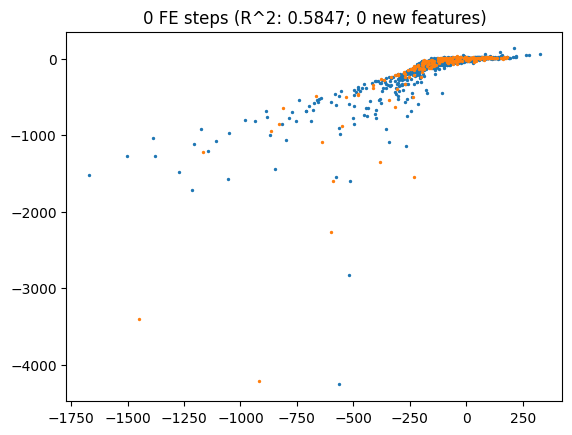

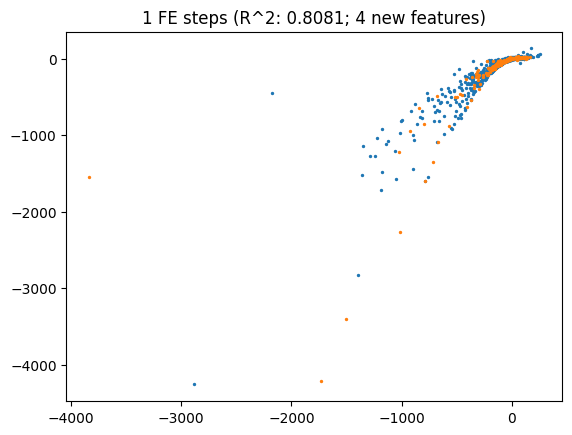

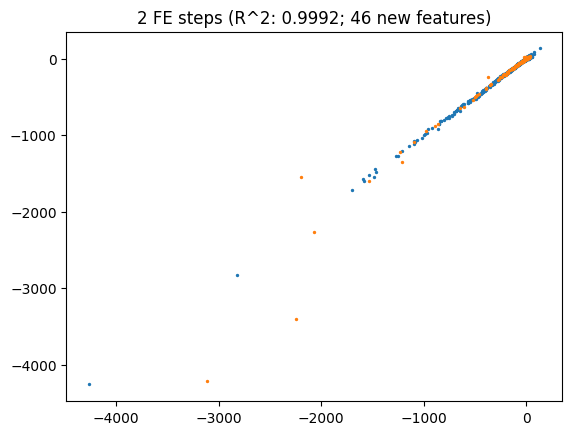

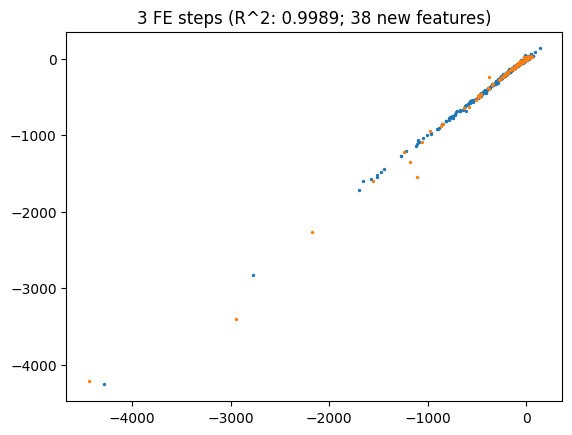

In [ ]:
# autofeat with different number of feature engineering steps
for steps in range(4):
    np.random.seed(42)
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    df = afreg.fit_transform(X_train, y_train)
    r2_train = afreg.score(X_train, y_train)
    r2_test = afreg.score(X_test, y_test)
    print("## Final Train R^2: %.4f" % r2_train)
    print("## Final Test R^2: %.4f" % r2_test)
    plt.figure()
    plt.scatter(afreg.predict(X_train), y_train, s=2)
    plt.scatter(afreg.predict(X_test), y_test, s=2)
    plt.title("%i FE steps (R^2: %.4f; %i new features)" % (steps, r2_train, len(afreg.new_feat_cols_)))

In [ ]:
target_noisy = target + 0.01*target.std()*np.random.randn(1000)
target_very_noisy = target + 0.1*target.std()*np.random.randn(1000)
target_very_very_noisy = target + target.std()*np.random.randn(1000)

[AutoFeat] The 3 step feature engineering process could generate up to 60445 features.
[AutoFeat] With 1000 data points this new feature matrix would use about 0.24 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 52 transformed features from 10 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 7500 feature combinations from 1891 original feature tuples - done.
[feateng] Step 3: transformation of new features


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[feateng] Generated 29858 transformed features from 7500 original features - done.
[feateng] Generated altogether 37862 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 26300 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 90 features after 5 feature selection runs
[featsel] 58 features after correlation filtering
[featsel] 43 features after noise filtering
[AutoFeat] Computing 41 new features.
[AutoFeat]    41/   41 new features ...done.
[AutoFeat] Final dataframe with 51 feature columns (41 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
61.68428697227955
-20.462876 * 1/(x1 + x5)
-17.614677 * 1/(x1**3 + sqrt(x5))
-13.439450 * x5*exp(-Abs(eng7))
-11.216251 * x

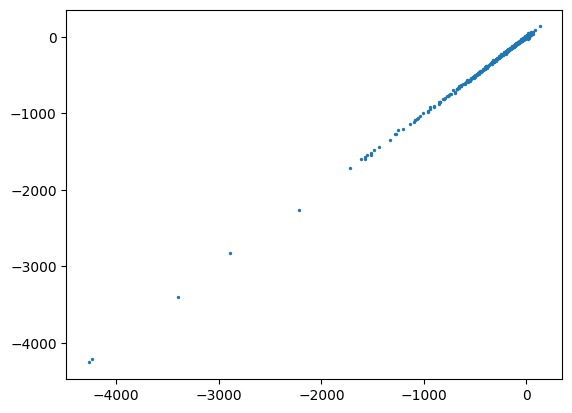

In [ ]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=3)
# train on noisy data
df = afreg.fit_transform(df_org, target_noisy)
# test on real targets
print("Final R^2: %.4f" % afreg.score(df, target))
plt.figure()
plt.scatter(afreg.predict(df), target, s=2)

[AutoFeat] The 3 step feature engineering process could generate up to 60445 features.
[AutoFeat] With 1000 data points this new feature matrix would use about 0.24 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 52 transformed features from 10 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 7500 feature combinations from 1891 original feature tuples - done.
[feateng] Step 3: transformation of new features


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[feateng] Generated 29858 transformed features from 7500 original features - done.
[feateng] Generated altogether 37862 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 26300 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 88 features after 5 feature selection runs
[featsel] 65 features after correlation filtering
[featsel] 30 features after noise filtering
[AutoFeat] Computing 29 new features.
[AutoFeat]    29/   29 new features ...done.
[AutoFeat] Final dataframe with 39 feature columns (29 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
45.981362888839044
-28.383785 * log(x1)*log(x5)
-19.684423 * x2*log(x1)
-18.692868 * x5*exp(-eng7**2)
-15.726897 * x2*log(x

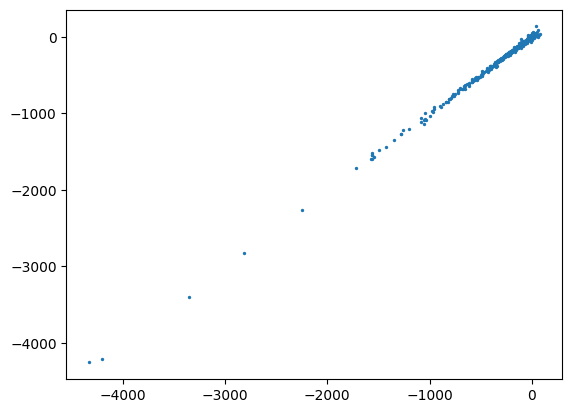

In [ ]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=3)
# train on noisy data
df = afreg.fit_transform(df_org, target_very_noisy)
# test on real targets
print("Final R^2: %.4f" % afreg.score(df, target))
plt.figure()
plt.scatter(afreg.predict(df), target, s=2);

[AutoFeat] The 3 step feature engineering process could generate up to 60445 features.
[AutoFeat] With 1000 data points this new feature matrix would use about 0.24 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 52 transformed features from 10 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 7500 feature combinations from 1891 original feature tuples - done.
[feateng] Step 3: transformation of new features


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[feateng] Generated 29858 transformed features from 7500 original features - done.
[feateng] Generated altogether 37862 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 26300 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 26 features after 5 feature selection runs
[featsel] 20 features after correlation filtering
[featsel] 11 features after noise filtering
[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.
[AutoFeat] Final dataframe with 21 feature columns (11 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
45.598343586160894
-62.356281 * log(x1)*log(x5)
5.968014 * (x2 + log(x5))**3
-4.320739 * sqrt(1/x5)*sqrt(Abs(eng7))
-4.2525

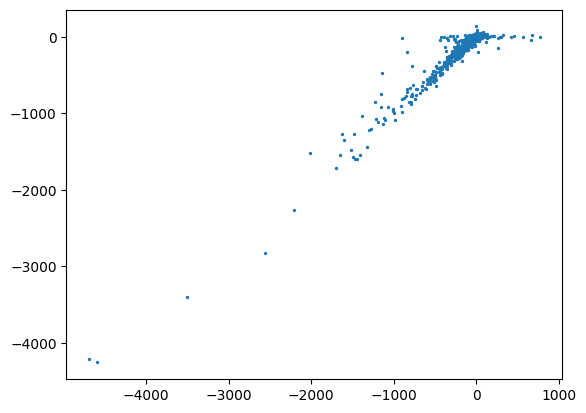

In [ ]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=3)
# train on noisy data
df = afreg.fit_transform(df_org, target_very_very_noisy)
# test on real targets
print("Final R^2: %.4f" % afreg.score(df, target))
plt.figure()
plt.scatter(afreg.predict(df), target, s=2);

#### Exercise -  Autofeat Regression on a real dataset



In [ ]:
from sklearn import datasets

# Load the diabetes dataset and get the featues and target
X, y = datasets.load_diabetes(return_X_y=True)

# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Instantiate an AutoFeatRegressor with 2 steps of feature engineering
afreg = AutoFeatRegressor(verbose=1, feateng_steps=2)

# Fit it on the train dataset
df = afreg.fit_transform(X_train, y_train)

# Get the R^2 for the train and test dataset and print it
r2_train = afreg.score(X_train, y_train)
r2_test = afreg.score(X_test, y_test)

print("## Final Train R^2: %.4f" % r2_train)
print("## Final Test R^2: %.4f" % r2_test)

[AutoFeat] The 2 step feature engineering process could generate up to 2485 features.
[AutoFeat] With 353 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 45 transformed features from 10 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 1334 feature combinations from 1485 original feature tuples - done.
[feateng] Generated altogether 1495 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 906 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 16 features after 5 feature selection runs
[featsel] 16 features after correlation filtering
[featsel] 14 features after noise filtering
[

#### Classification in AutoFeat

In [ ]:
from autofeat import AutoFeatClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris, load_breast_cancer

import warnings

In [ ]:
def test_autofeat_lr(X, y, feateng_steps=2, units = {}):

    # split in training and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    # run autofeat
    afreg = AutoFeatClassifier(verbose=1, feateng_steps=feateng_steps, units=units)

    X_train_tr = afreg.fit_transform(X_train, y_train)
    X_test_tr = afreg.transform(X_test)

    print("autofeat new features:", len(afreg.new_feat_cols_))
    print("autofeat Acc. on training data:", accuracy_score(y_train, afreg.predict(X_train_tr)))
    print("autofeat Acc. on test data:", accuracy_score(y_test, afreg.predict(X_test_tr)))

    # train rreg on transformed train split incl cross-validation for parameter selection
    print("# Logistic Regression")
    rreg = LogisticRegression(class_weight="balanced")
    param_grid = {"C": np.logspace(-4, 4, 10)}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gsmodel = GridSearchCV(rreg, param_grid, cv=5)
        gsmodel.fit(X_train_tr, y_train)

    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("Acc. on training data:", accuracy_score(y_train, gsmodel.predict(X_train_tr)))
    print("Acc. on test data:", accuracy_score(y_test, gsmodel.predict(X_test_tr)))
    print("# Random Forest")

In [ ]:
dsname = "iris"
X, y = load_iris(return_X_y=True)
X =np.array(X, dtype=float)
y = np.array(y, dtype=float)
print("####", dsname)
test_autofeat_lr(X,y, feateng_steps=2)

#### iris
[AutoFeat] The 2 step feature engineering process could generate up to 406 features.
[AutoFeat] With 120 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 24 transformed features from 4 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 362 feature combinations from 378 original feature tuples - done.
[feateng] Generated altogether 387 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 118 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 13 features after 5 feature selection runs
[featsel] 4 features after correlation filtering
[featsel] 4 features after noise filterin

### EXERCISE:

Use Breast Cancer dataset and run an AutoFeat classifier on it and compare it with an RandomForest model.

Set number of feature engg. steps as 1.


For RandomForest use :

- n_estimators=100
- use Grid Search with param_grid = {"min_samples_leaf": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]}
-  cv=5.
    

In [ ]:
def test_autofeat_rf(X, y, feateng_steps=2, units = {}):

    # split in training and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    # run autofeat
    afreg = AutoFeatClassifier(verbose=1, feateng_steps=feateng_steps, units=units)

    X_train_tr = afreg.fit_transform(X_train, y_train)
    X_test_tr = afreg.transform(X_test)

    print("autofeat new features:", len(afreg.new_feat_cols_))
    print("autofeat Acc. on training data:", accuracy_score(y_train, afreg.predict(X_train_tr)))
    print("autofeat Acc. on test data:", accuracy_score(y_test, afreg.predict(X_test_tr)))

    # train rreg on transformed train split incl cross-validation for parameter selection
    print("# Random Forest")
    rfor = RandomForestClassifier(n_estimators = 100)
    param_grid =  {"min_samples_leaf": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gsmodel = GridSearchCV(rfor, param_grid, cv=5)
        gsmodel.fit(X_train_tr, y_train)

    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("Acc. on training data:", accuracy_score(y_train, gsmodel.predict(X_train_tr)))
    print("Acc. on test data:", accuracy_score(y_test, gsmodel.predict(X_test_tr)))

dsname = "cancer"
X, y = load_breast_cancer(return_X_y=True)
X =np.array(X, dtype=float)
y = np.array(y, dtype=float)
print("####", dsname)
# Reduced feateng_steps to 1 because 2,3 were using up a lot of RAM
test_autofeat_rf(X,y, feateng_steps=1)


### References:
https://github.com/cod3licious/autofeat